# Data Acquisition

In [341]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize': (11.7, 8.27)})
plt.rcParams['axes.unicode_minus'] = False  # used to display minus signs normally

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame


In [343]:
def GET_csse_covid_19_time_series():

    print('Reading 【time series】 data......')
    repo = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'

    ts_confirmed_us = pd.read_csv(repo + 'time_series_covid19_confirmed_US.csv')
    ts_confirmed_global = pd.read_csv(repo + 'time_series_covid19_confirmed_global.csv')

    ts_deaths_us = pd.read_csv(repo + 'time_series_covid19_deaths_US.csv')
    ts_deaths_global = pd.read_csv(repo + 'time_series_covid19_deaths_global.csv')

    ts_recovered_global = pd.read_csv(repo + 'time_series_covid19_recovered_global.csv')

    print('Finished reading')
    return ts_confirmed_us, ts_confirmed_global, ts_deaths_us, ts_deaths_global, ts_recovered_global


In [345]:
ts_confirmed_us,ts_confirmed_global,ts_deaths_us,ts_deaths_global,ts_recovered_global = GET_csse_covid_19_time_series()

Reading 【time series】 data......
Finished reading


In [346]:
def GET_csse_covid_19_daily_reports():

    print('Reading 【cross-sectional】 data......')

    # Global
    ts_confirmed_us = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')

    latest = pd.to_datetime(ts_confirmed_us.columns[-1]).strftime('%m-%d-%Y')
    prev = (pd.to_datetime(ts_confirmed_us.columns[-1]) + timedelta(-1)).strftime('%m-%d-%Y')

    url_latest_global = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{latest}.csv'
    latest_data_global = pd.read_csv(url_latest_global)

    url_prev_global = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/{prev}.csv'
    prev_data_global = pd.read_csv(url_prev_global)

    url_latest_us = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/{latest}.csv'
    latest_data_us = pd.read_csv(url_latest_us)

    url_prev_us = f'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/{prev}.csv'
    prev_data_us = pd.read_csv(url_prev_us)

    print('Finished reading')
    return latest_data_global, prev_data_global, latest_data_us, prev_data_us

In [347]:
latest_data_global,prev_data_global,latest_data_us,prev_data_us = GET_csse_covid_19_daily_reports()

Reading 【cross-sectional】 data......
Finished reading


In [348]:
def GET_shanghai_data(plot=True, encoding="UTF-8"):
    import re
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    print('Fetching and processing 【Shanghai】 data (data from Shanghai Health Commission) ......')
    url = 'https://raw.githubusercontent.com/datoujinggzj/WhalePkg/master/DATA/ts_shanghai_covid.csv'
    data = pd.read_csv(url, encoding=encoding)['detail']
    print('Reading completed')

    data = data[data.apply(lambda x: x.startswith('上海202'))].sort_values()
    data = data.apply(lambda x: re.sub(r'\（.*?\）', '', x))  # Remove brackets
    data = data.apply(lambda x: x.replace('无新增', '0'))

    extracted = data.apply(lambda x: re.findall(r"\d+", x))
    # Only keep rows with at least 5 numbers, then take the first 5
    extracted = extracted[extracted.apply(lambda x: len(x) >= 5)]

    df_all = pd.DataFrame(extracted.apply(lambda x: x[:5]).tolist(),
                          columns=['Year', 'Month', 'Day', 'New Local Confirmed Cases', 'New Local Asymptomatic Cases'])

    df_all['Date'] = df_all['Year'].astype(str) + "/" + df_all['Month'].astype(str) + "/" + df_all['Day'].astype(str)
    df_all['Date'] = pd.to_datetime(df_all['Date'])
    df_all = df_all.set_index('Date').sort_index()
    df_all = df_all.astype('int32')
    df = df_all[['New Local Confirmed Cases', 'New Local Asymptomatic Cases']]

    if plot:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[10, 10])
        df_2022 = df[df.index > '2022-01-01']
        for col, ax in zip(df_2022.columns, axes):
            ax.step(df_2022.index, df_2022[col], color='#202124', linewidth=2)
            ax.bar(df_2022.index, df_2022[col], alpha=0.8)
            ax.vlines(x=pd.to_datetime("2022-04-01"), ymin=0, ymax=df[col].max(), linewidth=2, color='#4b7ffc', linestyle='--')
            ax.vlines(x=pd.to_datetime("2022-06-01"), ymin=0, ymax=df[col].max(), linewidth=2, color='#4b7ffc', linestyle='--')

            ax.hlines(y=df[col].max(), xmin=df_2022.index[0], xmax=df_2022.index[-1], linewidth=1, color='#ff0000')
            ax.text(x=df_2022.index[0], y=df[col].max(), s=df[col].max(), color='black', fontsize=14)
            ax.text(x=df_2022.index[0], y=df[col].max() / 2,
                    s=f"Peak:\nDate: {str(df.index[df[col].argmax()])} \nNew: {df[col].max()} cases",
                    color='#ff0000', fontsize=14)
            ax.text(x=df_2022.index[0], y=df[col].max() / 4,
                    s=f"Today:\nDate: {str(df.index[-1])} \nNew: {df[col][-1]} cases",
                    color='#ff0000', fontsize=14)

            ax.text(x=pd.to_datetime("2022-03-15"), y=df[col].max() * 2 / 3, s="Started as a joke\nApr 1, 2022",
                    color='black', fontsize=10)
            ax.text(x=pd.to_datetime("2022-05-15"), y=df[col].max() * 2 / 3, s="Ended in farce\nJun 1, 2022",
                    color='black', fontsize=10)

            ax.set_xlabel('Date')
            ax.set_ylabel(f'{col}')
            ax.set_title(f'Time Series Trend: {col}', fontsize=14)

        plt.tight_layout()

    return df


Fetching and processing 【Shanghai】 data (data from Shanghai Health Commission) ......
Reading completed


New Local Confirmed Cases  New Local Asymptomatic Cases
Date                                                               
2021-01-01                          0                             4
2021-01-02                          0                             6
2021-01-03                          0                             4
2021-01-04                          0                             6
2021-01-05                          0                             2
...                               ...                           ...
2022-06-07                          4                            11
2022-06-08                          4                             5
2022-06-09                          6                             5
2022-06-10                          7                             9
2022-06-11                         10                            19

[503 rows x 2 columns]

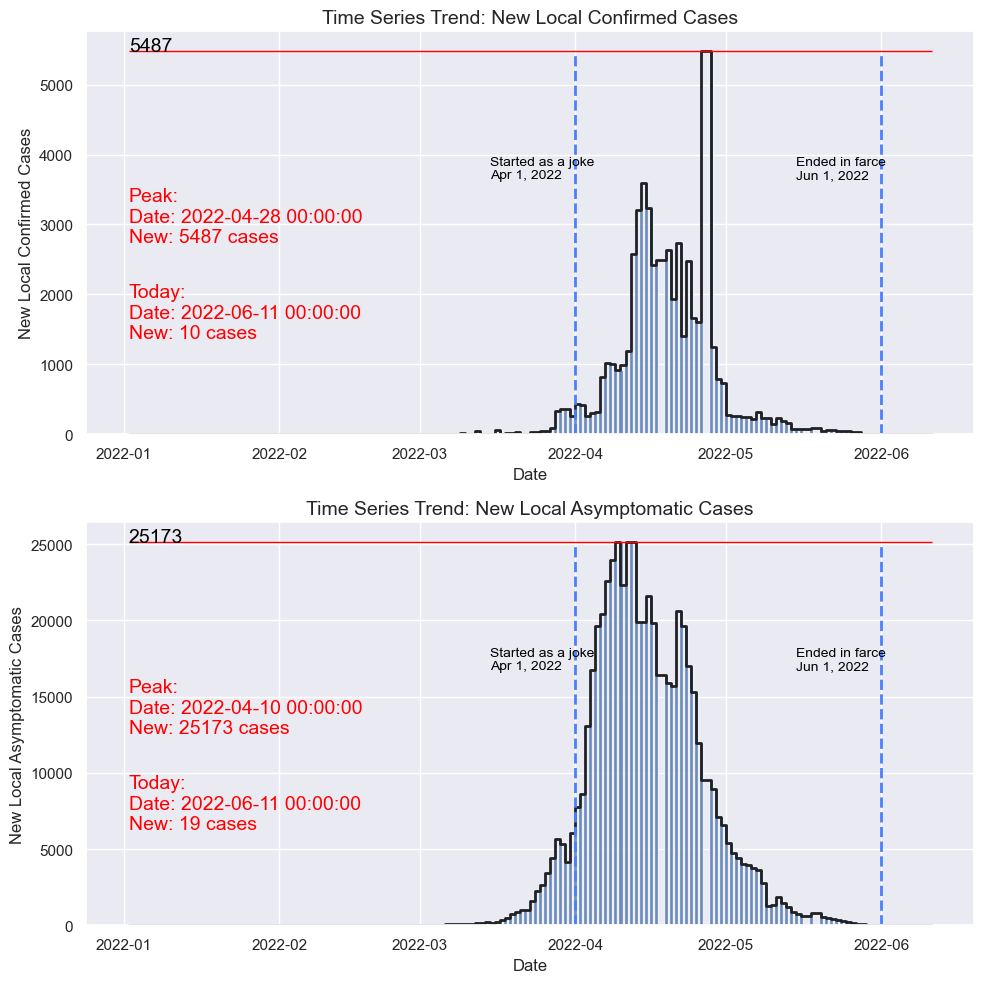

In [349]:
GET_shanghai_data(plot = True)

Reading 【cross-sectional】 data......
Finished reading
Reading 【time series】 data......
Finished reading
Fetching and processing 【Shanghai】 data (data from Shanghai Health Commission) ......
Reading completed


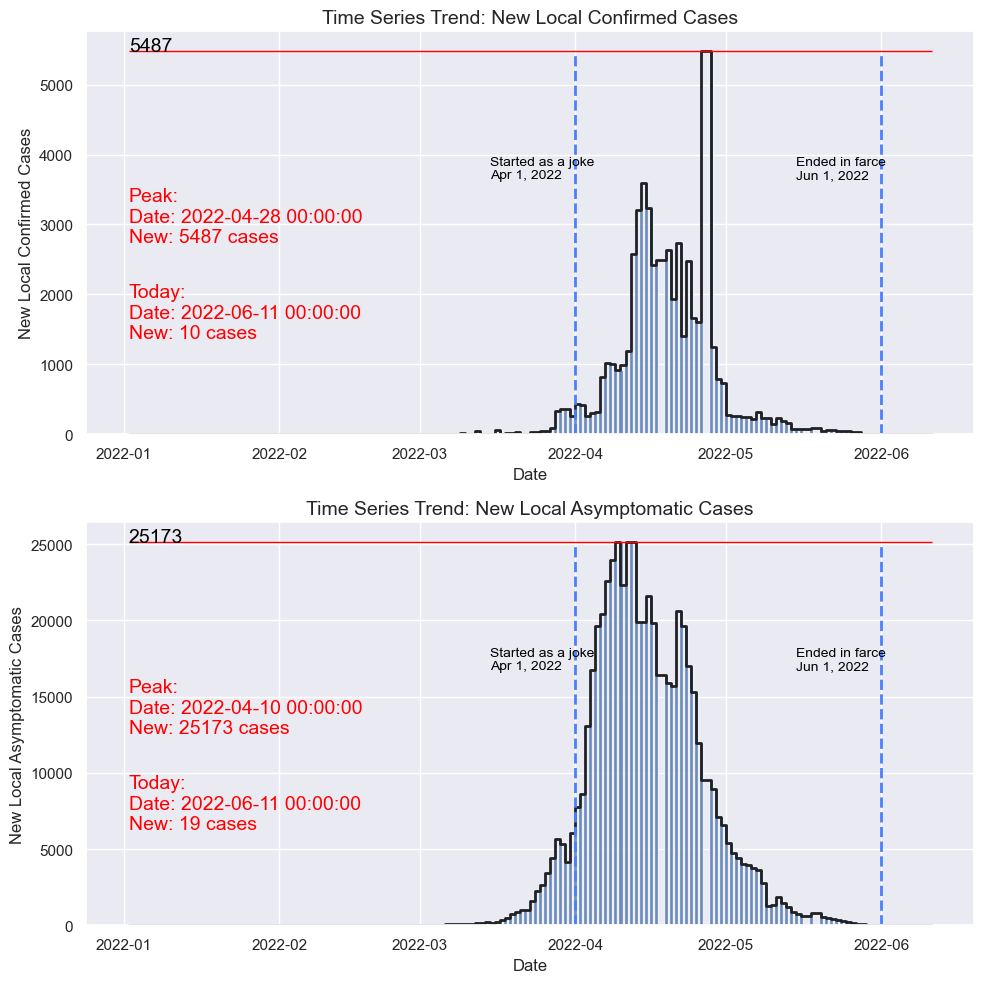

In [350]:

latest_data_global, prev_data_global, latest_data_us, prev_data_us = GET_csse_covid_19_daily_reports()
ts_confirmed_us, ts_confirmed_global, ts_deaths_us, ts_deaths_global, ts_recovered_global = GET_csse_covid_19_time_series()
ts_shanghai_covid = GET_shanghai_data(plot=True)


In [351]:
ts_confirmed_global.head()

Province/State Country/Region       Lat       Long  1/22/20  1/23/20  \
0            NaN    Afghanistan  33.93911  67.709953        0        0   
1            NaN        Albania  41.15330  20.168300        0        0   
2            NaN        Algeria  28.03390   1.659600        0        0   
3            NaN        Andorra  42.50630   1.521800        0        0   
4            NaN         Angola -11.20270  17.873900        0        0   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/28/23  3/1/23  3/2/23  3/3/23  \
0        0        0        0        0  ...   209322  209340  209358  209362   
1        0        0        0        0  ...   334391  334408  334408  334427   
2        0        0        0        0  ...   271441  271448  271463  271469   
3        0        0        0        0  ...    47866   47875   47875   47875   
4        0        0        0        0  ...   105255  105277  105277  105277   

   3/4/23  3/5/23  3/6/23  3/7/23  3/8/23  3/9/23  
0  209369  209390  209406  209436  209451  209451  
1  334427  334427  334427  334427  334443  334457  
2  271469  271477  271477  271490  271494  271496  
3   47875   47875   47875   47875   47890   47890  
4  105277  105277  105277  105277  105288  105288  

[5 rows x 1147 columns]

# China Time Series Data Processing

In [353]:
data1 = ts_confirmed_global.copy()  # Make a copy to avoid modifying the original data

# (1) Filter all data where Country/Region is China
data1 = data1[data1['Country/Region'] == 'China']

# (2) Set Province/State as the index
data1 = data1.set_index('Province/State')

# (3) Drop columns 'Country/Region', 'Lat', and 'Long' as we don't need them for now
data1 = data1.drop(['Country/Region', 'Lat', 'Long'], axis=1)

# (4) Calculate daily new cases by subtracting the previous day from the current day horizontally
# - axis=1 means the subtraction is done across columns (dates)
# - fillna is used because the first day's difference will be NaN, so we fill it with the original first day's cumulative cases
# - downcast='infer' preserves the original data type without needing an explicit .astype conversion
#
# Important!
# .clip(lower=0) can be added at the end if you want to replace negative values (which can occur) with zero.
data1 = data1.diff(axis=1).fillna({data1.columns[0]: data1[data1.columns[0]]}, downcast='infer')  # .clip(lower=0)

# (5) Sort the data by the latest day (the last column) in descending order, so provinces with highest new cases come first
data1 = data1.sort_values(by=data1.columns[-1], ascending=False)

# (6) Transpose the DataFrame (rotate 90 degrees), so dates become rows and provinces become columns
data1 = data1.T

# (7) Drop the 'Unknown' column, which usually appears due to missing province data (possibly Taiwan)
# Also drop any rows with missing values
data1 = data1.dropna().drop('Unknown', axis=1)

# (8) Convert the index (dates) to datetime format for proper time series handling
data1.index = pd.to_datetime(data1.index)

# (9) Remove the name of the columns index
data1.columns.name = ''

ts_data_processed = data1

# Now let's take a look at the processed data!
# ts_data_processed


In [354]:
def ts_process_CHINA(ts_data, clip=False):
    # Filter the dataset for rows where Country/Region is China
    ts_data = ts_data[ts_data['Country/Region'] == 'China']
    
    # Extract location data (province, latitude, longitude), excluding rows where Province/State is 'Unknown'
    loc_data = ts_data[['Province/State', 'Lat', 'Long']]
    loc_data = loc_data[loc_data['Province/State'] != 'Unknown']
    
    # Set Province/State as the index and drop unnecessary columns
    ts_data = ts_data.set_index('Province/State').drop(['Country/Region', 'Lat', 'Long'], axis=1)
    
    # Calculate daily new cases by differencing cumulative counts horizontally
    # Fill NaN in the first column with the original cumulative counts
    # Optionally clip negative values to zero if clip=True
    if clip:
        ts_data = ts_data.diff(axis=1).fillna({ts_data.columns[0]: ts_data[ts_data.columns[0]]}, downcast='infer').clip(lower=0)
    else:
        ts_data = ts_data.diff(axis=1).fillna({ts_data.columns[0]: ts_data[ts_data.columns[0]]}, downcast='infer')
    
    # Sort provinces by the latest day's new cases descendingly
    ts_data = ts_data.sort_values(by=ts_data.columns[-1], ascending=False)
    
    # Transpose so dates are the index and provinces are columns, drop rows with NaNs and the 'Unknown' province column
    ts_data = ts_data.T.dropna().drop('Unknown', axis=1)
    
    # Convert index to datetime type
    ts_data.index = pd.to_datetime(ts_data.index)
    
    # Remove the name of the columns index
    ts_data.columns.name = ''
    
    # Save the sorted list of provinces (column names)
    sorted_provinces = ts_data.columns
    
    # Return processed time series data, location data, and sorted provinces (for now you can ignore loc_data and sorted_provinces)
    return ts_data, loc_data, sorted_provinces


# American Time Series Data Processing

In [356]:
ts_confirmed_us.head()

UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region  \
0  84001001   US  USA    840  1001.0  Autauga        Alabama             US   
1  84001003   US  USA    840  1003.0  Baldwin        Alabama             US   
2  84001005   US  USA    840  1005.0  Barbour        Alabama             US   
3  84001007   US  USA    840  1007.0     Bibb        Alabama             US   
4  84001009   US  USA    840  1009.0   Blount        Alabama             US   

         Lat      Long_  ... 2/28/23  3/1/23  3/2/23  3/3/23  3/4/23  3/5/23  \
0  32.539527 -86.644082  ...   19732   19759   19759   19759   19759   19759   
1  30.727750 -87.722071  ...   69641   69767   69767   69767   69767   69767   
2  31.868263 -85.387129  ...    7451    7474    7474    7474    7474    7474   
3  32.996421 -87.125115  ...    8067    8087    8087    8087    8087    8087   
4  33.982109 -86.567906  ...   18616   18673   18673   18673   18673   18673   

   3/6/23  3/7/23  3/8/23  3/9/23  
0   19759   19759   19790   19790  
1   69767   69767   69860   69860  
2    7474    7474    7485    7485  
3    8087    8087    8091    8091  
4   18673   18673   18704   18704  

[5 rows x 1154 columns]

In [357]:
def ts_process_US(ts_data, death=False, clip=False):
    # Drop rows with any missing values
    ts_data = ts_data.dropna()
    
    # Extract location-related columns
    loc_data = ts_data[['UID', 'FIPS', 'Admin2', 'Province_State', 'Lat', 'Long_']]
    
    # Set multi-index with State and County, then select data columns starting from the 10th column onward (date columns)
    ts_data = ts_data.set_index(['Province_State', 'Admin2']).iloc[:, 9:]
    
    # If processing death data, compute population sums per state and drop the Population column from data
    if death:
        population = ts_data.groupby('Province_State')['Population'].sum()
        ts_data = ts_data.drop('Population', axis=1)
    
    # Calculate daily new cases (or deaths) by differencing cumulative counts horizontally
    # Fill NaN in the first column with the original cumulative counts
    # Optionally clip negative values to zero if clip=True
    if clip:
        ts_data = ts_data.diff(axis=1).fillna({ts_data.columns[0]: ts_data[ts_data.columns[0]]}, downcast='infer').clip(lower=0)
    else:
        ts_data = ts_data.diff(axis=1).fillna({ts_data.columns[0]: ts_data[ts_data.columns[0]]}, downcast='infer')
    
    # Sum daily counts by state (aggregating counties)
    ts_data = ts_data.groupby('Province_State').sum()
    
    # Sort states by the latest day's new cases descendingly
    ts_data = ts_data.sort_values(by=ts_data.columns[-1], ascending=False)
    
    # Transpose so dates are index and states are columns
    ts_data = ts_data.T
    
    # Convert index to datetime type
    ts_data.index = pd.to_datetime(ts_data.index)
    
    # Remove the name of columns index
    ts_data.columns.name = ''
    
    # Save sorted list of states (column names)
    sorted_state = ts_data.columns
    
    # Return results, with population only if death=True
    if death:
        return ts_data, loc_data, sorted_state, population
    return ts_data, loc_data, sorted_state


# Cross-sectional data processing between China and the United States

In [359]:
latest_data_global.head()

FIPS Admin2 Province_State Country_Region          Last_Update       Lat  \
0   NaN    NaN            NaN    Afghanistan  2023-03-10 04:21:03  33.93911   
1   NaN    NaN            NaN        Albania  2023-03-10 04:21:03  41.15330   
2   NaN    NaN            NaN        Algeria  2023-03-10 04:21:03  28.03390   
3   NaN    NaN            NaN        Andorra  2023-03-10 04:21:03  42.50630   
4   NaN    NaN            NaN         Angola  2023-03-10 04:21:03 -11.20270   

       Long_  Confirmed  Deaths  Recovered  Active Combined_Key  \
0  67.709953     209451    7896        NaN     NaN  Afghanistan   
1  20.168300     334457    3598        NaN     NaN      Albania   
2   1.659600     271496    6881        NaN     NaN      Algeria   
3   1.521800      47890     165        NaN     NaN      Andorra   
4  17.873900     105288    1933        NaN     NaN       Angola   

   Incident_Rate  Case_Fatality_Ratio  
0     538.042451             3.769855  
1   11621.968170             1.075774  
2     619.132366             2.534476  
3   61981.492267             0.344540  
4     320.352770             1.835917

In [360]:
def daily_process(daily_data, country = 'China'):
    if country == 'China':
        daily_data = daily_data[(daily_data['Country_Region'] == 'China')&(daily_data['Province_State']!='Unknown')]
    elif country == 'US':
        daily_data = daily_data
    cols_use = ['Province_State','Last_Update','Confirmed','Deaths','Incident_Rate','Case_Fatality_Ratio']

    # sorted_provinces is provided
    daily_data_processed = daily_data[cols_use].set_index(daily_data['Province_State'])
    daily_data_processed.index.name = ""
    daily_data_processed = daily_data_processed.dropna()
    return daily_data_processed

In [361]:
daily_process(latest_data_global, country = 'China')

Province_State          Last_Update  Confirmed  Deaths  \
                                                                         
Anhui                    Anhui  2023-03-10 04:21:03       2275       7   
Beijing                Beijing  2023-03-10 04:21:03      40774      20   
Chongqing            Chongqing  2023-03-10 04:21:03      14715      11   
Fujian                  Fujian  2023-03-10 04:21:03      17122       2   
Gansu                    Gansu  2023-03-10 04:21:03       1742       2   
Guangdong            Guangdong  2023-03-10 04:21:03     103248      10   
Guangxi                Guangxi  2023-03-10 04:21:03      13371       2   
Guizhou                Guizhou  2023-03-10 04:21:03       2534       2   
Hainan                  Hainan  2023-03-10 04:21:03      10483       6   
Hebei                    Hebei  2023-03-10 04:21:03       3292       7   
Heilongjiang      Heilongjiang  2023-03-10 04:21:03       6603      18   
Henan                    Henan  2023-03-10 04:21:03       9948      23   
Hong Kong            Hong Kong  2023-03-10 04:21:03    2876106   13467   
Hubei                    Hubei  2023-03-10 04:21:03      72131    4515   
Hunan                    Hunan  2023-03-10 04:21:03       7437       4   
Inner Mongolia  Inner Mongolia  2023-03-10 04:21:03       8847       1   
Jiangsu                Jiangsu  2023-03-10 04:21:03       5075       0   
Jiangxi                Jiangxi  2023-03-10 04:21:03       3423       2   
Jilin                    Jilin  2023-03-10 04:21:03      40764       5   
Liaoning              Liaoning  2023-03-10 04:21:03       3547       2   
Macau                    Macau  2023-03-10 04:21:03       3514     121   
Ningxia                Ningxia  2023-03-10 04:21:03       1276       0   
Qinghai                Qinghai  2023-03-10 04:21:03        782       0   
Shaanxi                Shaanxi  2023-03-10 04:21:03       7326       5   
Shandong              Shandong  2023-03-10 04:21:03       5880      10   
Shanghai              Shanghai  2023-03-10 04:21:03      67040     595   
Shanxi                  Shanxi  2023-03-10 04:21:03       7167       1   
Sichuan                Sichuan  2023-03-10 04:21:03      14567      12   
Tianjin                Tianjin  2023-03-10 04:21:03       4392       3   
Tibet                    Tibet  2023-03-10 04:21:03       1647       0   
Xinjiang              Xinjiang  2023-03-10 04:21:03       3089       3   
Yunnan                  Yunnan  2023-03-10 04:21:03       9743       4   
Zhejiang              Zhejiang  2023-03-10 04:21:03      11848       1   

                Incident_Rate  Case_Fatality_Ratio  
                                                    
Anhui                3.597407             0.307692  
Beijing            189.294336             0.049051  
Chongqing           47.437137             0.074754  
Fujian              43.445826             0.011681  
Gansu                6.605992             0.114811  
Guangdong           90.999471             0.009685  
Guangxi             27.143727             0.014958  
Guizhou              7.038889             0.078927  
Hainan             112.237687             0.057236  
Hebei                4.356803             0.212637  
Heilongjiang        17.500663             0.272603  
Henan               10.357106             0.231202  
Hong Kong        38363.486776             0.468237  
Hubei              121.904681             6.259445  
Hunan               10.779823             0.053785  
Inner Mongolia      34.913181             0.011303  
Jiangsu              6.303565             0.000000  
Jiangxi              7.364458             0.058428  
Jilin              150.754438             0.012266  
Liaoning             8.137187             0.056386  
Macau              541.163208             3.443369  
Ningxia             18.546512             0.000000  
Qinghai             12.968491             0.000000  
Shaanxi             18.959627             0.068250  
Shandong             5.852493             0.170

In [362]:
from data_processing import ts_process_CHINA,ts_process_US,daily_process

In [363]:
ts_confirmed_CHINA_incre, loc_data_CHINA, sorted_provinces = ts_process_CHINA(ts_confirmed_global,clip=False)
ts_deaths_CHINA_incre, _, _ = ts_process_CHINA(ts_deaths_global,clip=False)
ts_recovered_CHINA_incre, _, _ = ts_process_CHINA(ts_recovered_global,clip=False)

In [366]:
ts_confirmed_US_incre,loc_data_us,sorted_state = ts_process_US(ts_confirmed_us,clip=False)
ts_deaths_US_incre,_,_,population = ts_process_US(ts_deaths_us,death = True,clip=False)

In [367]:
latest_data_CHINA = daily_process(latest_data_global, country = 'China')
prev_data_CHINA = daily_process(prev_data_global, country = 'China')
latest_data_US = daily_process(latest_data_us, country = 'US')
prev_data_US = daily_process(prev_data_us, country = 'US')

# Data quality inspection

In [369]:
neg_incre_date_CHINA = []
neg_incre_province_CHINA = []
neg_incre_number_CHINA = []
for r,c in sorted(zip(np.where(ts_confirmed_CHINA_incre<0)[0],np.where(ts_confirmed_CHINA_incre<0)[1]),key = lambda x: x[0],reverse=True):
    neg_incre_date_CHINA.append(str(ts_confirmed_CHINA_incre.index[r]))
    neg_incre_province_CHINA.append(ts_confirmed_CHINA_incre.columns[c])
    neg_incre_number_CHINA.append(ts_confirmed_CHINA_incre.iloc[r,c])

In [370]:
from tabulate import tabulate

print(tabulate(
    sorted(
        zip(neg_incre_date_CHINA, neg_incre_province_CHINA, neg_incre_number_CHINA),
        key=lambda x: abs(x[2]),
        reverse=True
    ),
    headers=['Date of Negative Increase', 'Location', 'Amount'],
    tablefmt='pretty'
))


+---------------------------+--------------+--------+
| Date of Negative Increase |   Location   | Amount |
+---------------------------+--------------+--------+
|    2022-04-20 00:00:00    |   Shanghai   |  -589  |
|    2023-01-09 00:00:00    |    Macau     |  -265  |
|    2023-01-08 00:00:00    |   Liaoning   |  -244  |
|    2022-12-17 00:00:00    |    Fujian    |  -73   |
|    2022-12-17 00:00:00    |   Jiangsu    |  -27   |
|    2021-10-09 00:00:00    |  Hong Kong   |  -23   |
|    2022-04-15 00:00:00    |    Yunnan    |  -12   |
|    2022-12-17 00:00:00    |    Tibet     |   -7   |
|    2020-06-03 00:00:00    |   Jiangxi    |   -5   |
|    2021-10-14 00:00:00    | Heilongjiang |   -4   |
|    2022-12-17 00:00:00    |    Hubei     |   -1   |
|    2022-12-17 00:00:00    |    Jilin     |   -1   |
|    2022-02-09 00:00:00    |   Liaoning   |   -1   |
|    2021-10-14 00:00:00    |    Hebei     |   -1   |
|    2021-09-03 00:00:00    |  Hong Kong   |   -1   |
|    2021-06-28 00:00:00    

In [371]:
neg_incre_date_US = []
neg_incre_province_US = []
neg_incre_number_US = []

# Find indices where the US confirmed incremental cases are negative
for r, c in sorted(zip(np.where(ts_confirmed_US_incre < 0)[0], np.where(ts_confirmed_US_incre < 0)[1]), key=lambda x: x[0], reverse=True):
    neg_incre_date_US.append(str(ts_confirmed_US_incre.index[r]))        # Append date of negative increase
    neg_incre_province_US.append(ts_confirmed_US_incre.columns[c])       # Append province/state name
    neg_incre_number_US.append(ts_confirmed_US_incre.iloc[r, c])         # Append negative value

# Print a pretty table sorted by absolute value of the negative increases, descending
print(tabulate(
    sorted(zip(neg_incre_date_US, neg_incre_province_US, neg_incre_number_US), key=lambda x: abs(x[2]), reverse=True),
    headers=['Date of Negative Increase', 'Location', 'Amount'],
    tablefmt='pretty'
))


+---------------------------+----------------------+--------+
| Date of Negative Increase |       Location       | Amount |
+---------------------------+----------------------+--------+
|    2022-08-17 00:00:00    |       Florida        | -27000 |
|    2021-04-26 00:00:00    |      New Jersey      | -9005  |
|    2022-01-26 00:00:00    |       Alabama        | -8780  |
|    2022-10-26 00:00:00    |       Nebraska       | -8099  |
|    2021-04-17 00:00:00    |       Missouri       | -7698  |
|    2023-02-20 00:00:00    |       Missouri       | -6071  |
|    2023-03-05 00:00:00    |      Tennessee       | -5128  |
|    2021-03-11 00:00:00    |       Missouri       | -4354  |
|    2022-02-08 00:00:00    |     Pennsylvania     | -4116  |
|    2021-06-29 00:00:00    |      California      | -3940  |
|    2022-05-11 00:00:00    |       Nebraska       | -3764  |
|    2023-01-17 00:00:00    |       Colorado       | -3133  |
|    2022-05-05 00:00:00    |    South Carolina    | -3073  |
|    202

In [372]:
import numpy as np
from tabulate import tabulate

def negincre_report(ts_data, sort_by=0):
    """
    Report negative increments in time series data.

    Parameters:
    - ts_data: pd.DataFrame, time series with dates as index, locations as columns.
    - sort_by: int, 0=date, 1=place, 2=number (absolute value)

    Prints:
    - Most recent date of nationwide negative growth.
    - Table of negative increments sorted by the chosen key.
    """
    neg_incre_date = []
    neg_incre_province = []
    neg_incre_number = []
    
    # Get all positions where data < 0
    neg_positions = np.where(ts_data < 0)
    
    # Sort by row (date) descending
    sorted_positions = sorted(zip(neg_positions[0], neg_positions[1]), key=lambda x: x[0], reverse=True)
    
    for r, c in sorted_positions:
        neg_incre_date.append(str(ts_data.index[r]))
        neg_incre_province.append(ts_data.columns[c])
        neg_incre_number.append(ts_data.iloc[r, c])
    
    # Find most recent date with nationwide negative growth
    recent_dates = ts_data.index[ts_data.sum(axis=1) < 0]
    recent_date = recent_dates[0] if len(recent_dates) > 0 else 'None'
    
    print('*' * 20 + ' INFO ' + '*' * 20)
    print(f"Most recent nationwide negative growth date: {recent_date}")
    
    print('*' * 20 + ' REPORT ' + '*' * 20)
    print(tabulate(
        sorted(
            zip(neg_incre_date, neg_incre_province, neg_incre_number),
            key=lambda x: abs(x[2]) if sort_by == 2 else x[sort_by],
            reverse=True
        ),
        headers=['Date', 'Location', 'Negative Increment'],
        tablefmt='pretty'
    ))


In [374]:
from colorama import Fore, Style, init

def dataQC(data):
    init(autoreset=True)  # 初始化colorama，自动重置颜色
    print(f"Total rows: {Fore.RED}{data.shape[0]}{Style.RESET_ALL}")
    print(f"Total columns: {Fore.RED}{data.shape[1]}{Style.RESET_ALL}")
    print(f"Total elements: {data.size}")
    print('-'*50 + f"{Fore.RED} INFO {Style.RESET_ALL}" + '-'*50)
    print('【Basic Info】')
    data.info()


In [375]:
dataQC(latest_data_CHINA)

Total rows: 33
Total columns: 6
Total elements: 198
-------------------------------------------------- INFO --------------------------------------------------
【Basic Info】
<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, Anhui to Zhejiang
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Province_State       33 non-null     object 
 1   Last_Update          33 non-null     object 
 2   Confirmed            33 non-null     int64  
 3   Deaths               33 non-null     int64  
 4   Incident_Rate        33 non-null     float64
 5   Case_Fatality_Ratio  33 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.8+ KB


In [378]:
#draw a time series trend chart of the covid situation in each province of China
#And add the 7-day moving average and 30-day moving average curves

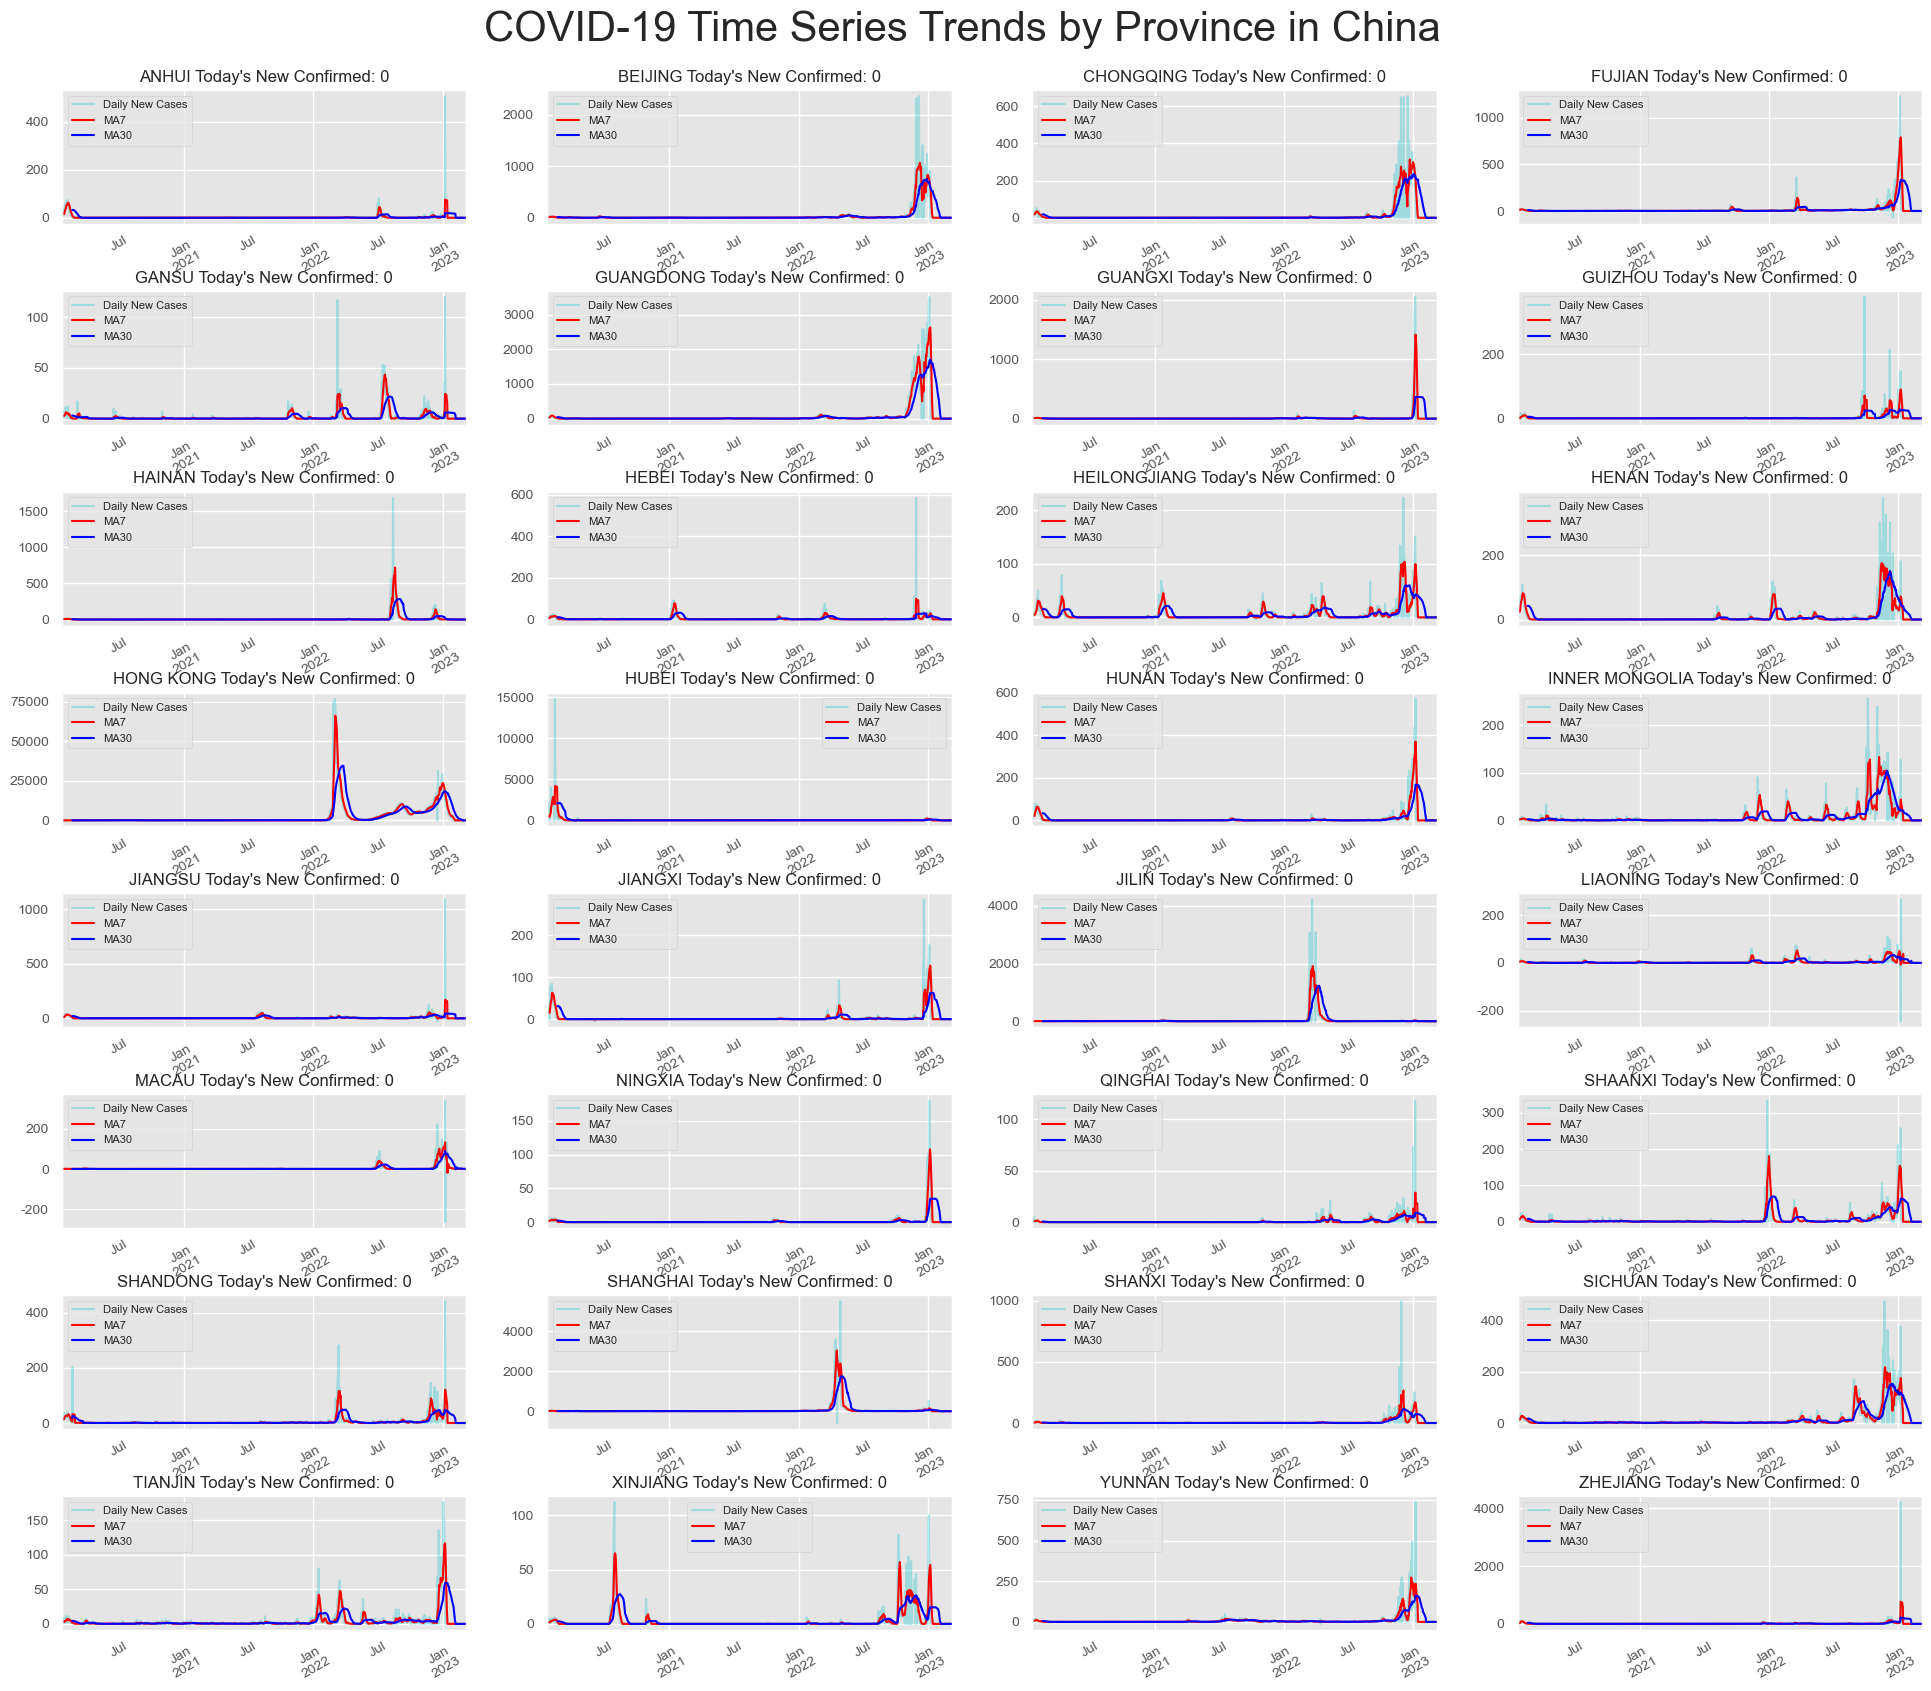

In [379]:
country = 'China'
ma = [7, 30]
method = 'New Cases'
kind = 'Confirmed'

data_copy = ts_confirmed_CHINA_incre.copy()

# Drop Tibet column and sort provinces by latest day's new cases descending
data_copy = data_copy.drop(['Tibet'], axis=1).sort_values(by=data_copy.index[-1], axis=1, ascending=False)

plt.style.use('ggplot')
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(24, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle(f"COVID-19 Time Series Trends by Province in {country}", fontsize=30, y=0.92)

for province, ax in zip(data_copy.columns, axs.ravel()):
    # Plot raw daily increments
    data_copy[province].plot(ax=ax, rot=30, fontsize=10, alpha=0.3, label='Daily New Cases', color='#06c3cc')
    
    # Plot moving averages
    data_copy[province].rolling(ma[0]).mean().plot(ax=ax, rot=30, fontsize=10, label=f'MA{ma[0]}', color='red')
    data_copy[province].rolling(ma[1]).mean().plot(ax=ax, rot=30, fontsize=10, label=f'MA{ma[1]}', color='blue')
    
    # Set the subplot title with province name and today's new confirmed cases count
    today_cases = int(data_copy[province].iloc[-1])
    ax.set_title(f"{province.upper()} Today's New {kind}: {today_cases}", fontsize=12)
    
    ax.legend(fontsize=8)
    ax.set_xlabel("")

plt.show()


In [380]:
import plotly.graph_objs as go
from plotly.graph_objs import Layout
from plotly import offline

data_copy1 = ts_confirmed_US_incre  # Your US confirmed cases daily increment DataFrame

specify = 'New York'  # Specify the state to plot
idx = data_copy1.index  # The datetime index
ser = data_copy1[specify]  # Time series data for New York

layout_title = specify.upper()  # Uppercase title for layout
kind = 'Confirmed'  # Case type
method = 'New Cases'  # Method/metric

ma = [7, 30]  # Moving average windows: 7-day and 30-day

# Trace for raw daily new cases with lines and markers
trace = go.Scatter(
    x=idx,
    y=ser,
    mode='lines+markers',
    name=f'{method} {kind} Count',
    opacity=0.8,
    line=dict(color="#08a8c4", width=0.4),
    marker=dict(color='#5857e1', size=1.2)
)

# Trace for 7-day moving average
trace1 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[0]).mean(),
    mode='lines+markers',
    name=f'{ma[0]}-Day Moving Average',
    opacity=0.6,
    line=dict(color="#ee5090", width=1.4),
    marker=dict(color='#dd001b', size=2.2)
)

# Trace for 30-day moving average
trace2 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[1]).mean(),
    mode='lines+markers',
    name=f'{ma[1]}-Day Moving Average',
    opacity=0.8,
    line=dict(color="#006eff", width=2.4),
    marker=dict(color='#412b63', size=3.2)
)

plotdata = [trace, trace1, trace2]

# Configure x-axis and y-axis titles
x_axis_config = {'title': 'Date'}
y_axis_config = {'title': f'{kind} Count ({method.upper()})'}

# Define the plot layout with title and axis config
my_layout = Layout(
    title=f"[{layout_title}] Recent {kind} Time Series Line Chart ({method.upper()})",
    xaxis=x_axis_config,
    yaxis=y_axis_config
)

# Generate and show the interactive plot in Jupyter Notebook
offline.iplot(
    {'data': plotdata, 'layout': my_layout},
    filename=f'{layout_title}_COVID_TS',
    image_height=500,
    image_width=1000,
    image='png'
)


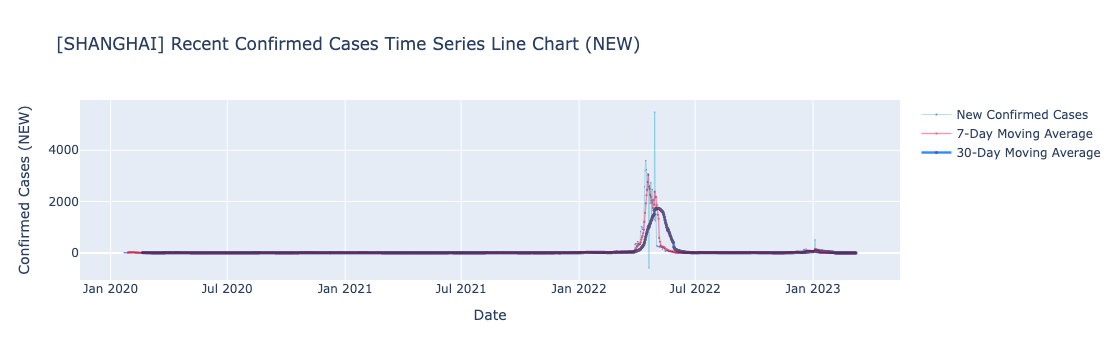

In [381]:
import plotly.graph_objs as go
from plotly.graph_objs import Layout
from plotly import offline

# Select dataset for visualization
data_copy1 = ts_confirmed_CHINA_incre

# Specify the province (Shanghai)
specify = 'Shanghai'
idx = data_copy1.index
ser = data_copy1[specify]
layout_title = specify.upper()
case_type = 'Confirmed'
method = 'New'
ma = [7, 30]  # Moving average windows (7 and 30 days)

# Trace for raw daily new confirmed cases
trace = go.Scatter(
    x=idx,
    y=ser,
    mode='lines+markers',
    name=f'{method} {case_type} Cases',
    opacity=0.8,
    line=dict(color="#08a8c4", width=0.4),
    marker=dict(color='#5857e1', size=1.2)
)

# Trace for 7-day moving average
trace1 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[0]).mean(),
    mode='lines+markers',
    name=f'{ma[0]}-Day Moving Average',
    opacity=0.6,
    line=dict(color="#ee5090", width=1.4),
    marker=dict(color='#dd001b', size=2.2)
)

# Trace for 30-day moving average
trace2 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[1]).mean(),
    mode='lines+markers',
    name=f'{ma[1]}-Day Moving Average',
    opacity=0.8,
    line=dict(color="#006eff", width=2.4),
    marker=dict(color='#412b63', size=3.2)
)

plotdata = [trace, trace1, trace2]

# Start plotting

x_axis_config = {'title': 'Date'}
y_axis_config = {'title': f'{case_type} Cases ({method.upper()})'}

# Configure chart layout
my_layout = Layout(
    title=f"[{layout_title}] Recent {case_type} Cases Time Series Line Chart ({method.upper()})",
    xaxis=x_axis_config,
    yaxis=y_axis_config
)

# Generate the plot (interactive in Jupyter Notebook)
offline.iplot(
    {'data': plotdata, 'layout': my_layout},
    filename=f'{layout_title}_COVID_TS',
    image_height=500,
    image_width=1000,
    image='png'
)


In [382]:
import plotly.graph_objs as go
from plotly.graph_objs import Layout
from plotly import offline

# Select dataset for visualization
data_copy1 = ts_confirmed_CHINA_incre

# Specify region ('China' in this case)
specify = 'China'
idx = data_copy1.index
ser = data_copy1.sum(axis=1)  # Sum across all provinces for national data
layout_title = specify.upper()
case_type = 'Confirmed'
method = 'New'
ma = [7, 30]  # Moving average windows (7 days, 30 days)

# Trace for raw daily new confirmed cases
trace = go.Scatter(
    x=idx,
    y=ser,
    mode='lines+markers',
    name=f'{method} {case_type} Cases',
    opacity=0.8,
    line=dict(color="#08a8c4", width=0.4),
    marker=dict(color='#5857e1', size=1.2)
)

# Trace for 7-day moving average
trace1 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[0]).mean(),
    mode='lines+markers',
    name=f'{ma[0]}-Day Moving Average',
    opacity=0.6,
    line=dict(color="#ee5090", width=1.4),
    marker=dict(color='#dd001b', size=2.2)
)

# Trace for 30-day moving average
trace2 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[1]).mean(),
    mode='lines+markers',
    name=f'{ma[1]}-Day Moving Average',
    opacity=0.8,
    line=dict(color="#006eff", width=2.4),
    marker=dict(color='#412b63', size=3.2)
)

plotdata = [trace, trace1, trace2]

# Plot configuration
x_axis_config = {'title': 'Date'}
y_axis_config = {'title': f'{case_type} Cases ({method.upper()})'}

# Set up the layout of the plot
my_layout = Layout(
    title=f"[{layout_title}] Recent {case_type} Cases Time Series Line Chart ({method.upper()})",
    xaxis=x_axis_config,
    yaxis=y_axis_config
)

# Generate the plot (interactive in Jupyter Notebook)
offline.iplot(
    {'data': plotdata, 'layout': my_layout},
    filename=f'{layout_title}_COVID_TS',
    image_height=500,
    image_width=1000,
    image='png'
)


In [383]:
import plotly.graph_objs as go
from plotly.graph_objs import Layout
from plotly import offline

# Dataset for visualization
data_copy1 = ts_confirmed_CHINA_incre

# Specify region (Mainland China, excluding Hong Kong)
specify = 'Mainland China'
idx = data_copy1.index
ser = data_copy1.drop('Hong Kong', axis=1).sum(axis=1)
layout_title = specify.upper()
case_type = 'Confirmed'
method = 'New'
ma = [7, 30]  # Moving average windows (7 days, 30 days)

# Trace for raw daily new confirmed cases
trace = go.Scatter(
    x=idx,
    y=ser,
    mode='lines+markers',
    name=f'{method} {case_type} Cases',
    opacity=0.8,
    line=dict(color="#08a8c4", width=0.4),
    marker=dict(color='#5857e1', size=1.2)
)

# Trace for 7-day moving average
trace1 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[0]).mean(),
    mode='lines+markers',
    name=f'{ma[0]}-Day Moving Average',
    opacity=0.6,
    line=dict(color="#ee5090", width=1.4),
    marker=dict(color='#dd001b', size=2.2)
)

# Trace for 30-day moving average
trace2 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[1]).mean(),
    mode='lines+markers',
    name=f'{ma[1]}-Day Moving Average',
    opacity=0.8,
    line=dict(color="#006eff", width=2.4),
    marker=dict(color='#412b63', size=3.2)
)

plotdata = [trace, trace1, trace2]

# Start plotting

x_axis_config = {'title': 'Date'}
y_axis_config = {'title': f'{case_type} Cases ({method.upper()})'}

# Configure chart layout
my_layout = Layout(
    title=f"[{layout_title}] Recent {case_type} Cases Time Series Line Chart ({method.upper()})",
    xaxis=x_axis_config,
    yaxis=y_axis_config
)

# Generate the plot (interactive in Jupyter Notebook)
offline.iplot(
    {'data': plotdata, 'layout': my_layout},
    filename=f'{layout_title}_COVID_TS',
    image_height=500,
    image_width=1000,
    image='png'
)


In [384]:
import plotly.graph_objs as go
from plotly.graph_objs import Layout
from plotly import offline

# Dataset for visualization
data_copy1 = ts_confirmed_US_incre

# Specify region (USA)
specify = 'United States'
idx = data_copy1.index
ser = data_copy1.sum(axis=1)  # Aggregate to national level
layout_title = specify.upper()
case_type = 'Confirmed'
method = 'New'
ma = [7, 30]  # Moving average windows (7 days, 30 days)

# Trace for raw daily new confirmed cases
trace = go.Scatter(
    x=idx,
    y=ser,
    mode='lines+markers',
    name=f'{method} {case_type} Cases',
    opacity=0.8,
    line=dict(color="#08a8c4", width=0.4),
    marker=dict(color='#5857e1', size=1.2)
)

# Trace for 7-day moving average
trace1 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[0]).mean(),
    mode='lines+markers',
    name=f'{ma[0]}-Day Moving Average',
    opacity=0.6,
    line=dict(color="#ee5090", width=1.4),
    marker=dict(color='#dd001b', size=2.2)
)

# Trace for 30-day moving average
trace2 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[1]).mean(),
    mode='lines+markers',
    name=f'{ma[1]}-Day Moving Average',
    opacity=0.8,
    line=dict(color="#006eff", width=2.4),
    marker=dict(color='#412b63', size=3.2)
)

plotdata = [trace, trace1, trace2]

# Plot configuration
x_axis_config = {'title': 'Date'}
y_axis_config = {'title': f'{case_type} Cases ({method.upper()})'}

# Configure chart layout
my_layout = Layout(
    title=f"[{layout_title}] Recent {case_type} Cases Time Series Line Chart ({method.upper()})",
    xaxis=x_axis_config,
    yaxis=y_axis_config
)

# Generate the plot (interactive in Jupyter Notebook)
offline.iplot(
    {'data': plotdata, 'layout': my_layout},
    filename=f'{layout_title}_COVID_TS',
    image_height=500,
    image_width=1000,
    image='png'
)


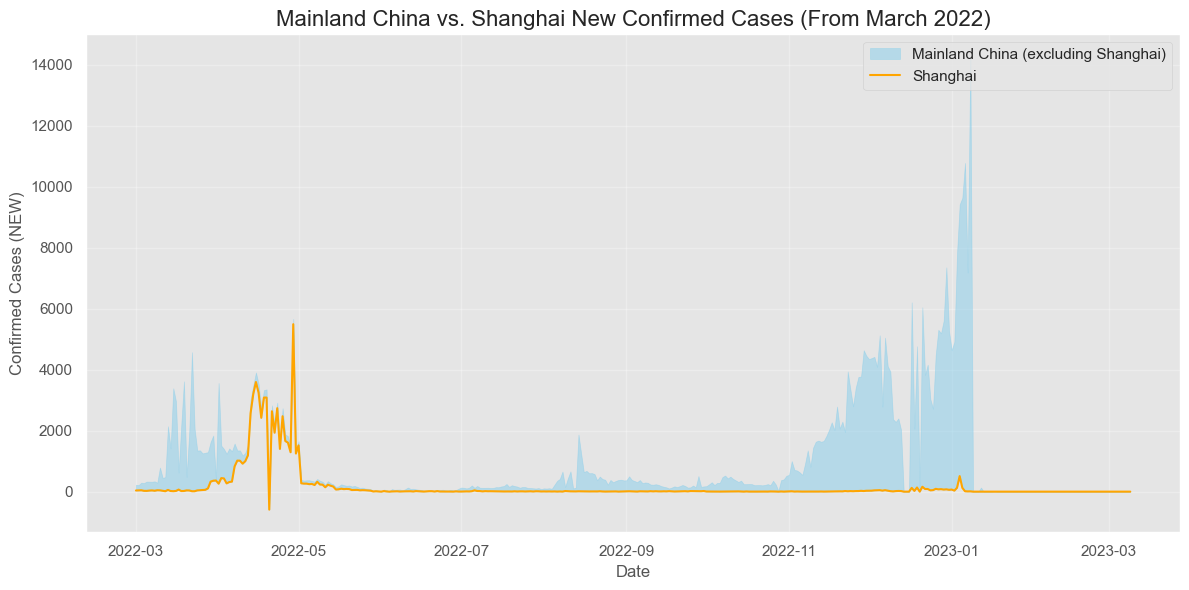

In [385]:
import plotly.graph_objs as go
from plotly.graph_objs import Layout
from plotly import offline
import matplotlib.pyplot as plt

# Filter data from March 1, 2022, onward
data_copy1 = ts_confirmed_CHINA_incre[ts_confirmed_CHINA_incre.index >= '2022-03-01']

# Specify the comparison label for the chart
specify = 'Mainland China vs. Shanghai'
idx = data_copy1.index
ser = data_copy1.drop('Hong Kong', axis=1).sum(axis=1)  # Total mainland China confirmed cases

layout_title = specify.upper()
case_type = 'Confirmed'
method = 'New'
ma = [7, 30]  # Moving average periods: 7 and 30 days

# Trace for total mainland China new confirmed cases
trace = go.Scatter(
    x=idx,
    y=ser,
    mode='lines+markers',
    name=f'{method} {case_type} Cases',
    opacity=0.8,
    line=dict(color="#08a8c4", width=0.4),
    marker=dict(color='#5857e1', size=1.2)
)

# Trace for 7-day moving average
trace1 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[0]).mean(),
    mode='lines+markers',
    name=f'{ma[0]}-Day Moving Average',
    opacity=0.6,
    line=dict(color="#ee5090", width=1.4),
    marker=dict(color='#dd001b', size=2.2)
)

# Trace for 30-day moving average
trace2 = go.Scatter(
    x=idx,
    y=ser.rolling(ma[1]).mean(),
    mode='lines+markers',
    name=f'{ma[1]}-Day Moving Average',
    opacity=0.8,
    line=dict(color="#006eff", width=2.4),
    marker=dict(color='#412b63', size=3.2)
)

# Trace for Shanghai's new confirmed cases
trace3 = go.Scatter(
    x=idx,
    y=data_copy1['Shanghai'],
    mode='lines+markers',
    name='Shanghai New Cases',
    opacity=0.8,
    line=dict(color="#f3832c", width=1.4),
    marker=dict(color='#d90013', size=3.2)
)

plotdata = [trace, trace1, trace2, trace3]

# Plot configuration
x_axis_config = {'title': 'Date'}
y_axis_config = {'title': f'{case_type} Cases ({method.upper()})'}

# Chart layout
my_layout = Layout(
    title=f"[{layout_title}] Recent {case_type} Cases Time Series Line Chart ({method.upper()}) — From March 2022 to Present",
    xaxis=x_axis_config,
    yaxis=y_axis_config
)

# Generate interactive plot
offline.iplot({'data': plotdata, 'layout': my_layout}, 
              filename=f'{layout_title}_COVID_TS',
              image_height=500, image_width=1000, image='png')

# ===============================
# Matplotlib Chart (Stacked Fill)
# ===============================
plt.figure(figsize=[12, 6])

# Filled area plot to show difference between Mainland China total and Shanghai cases
plt.fill_between(
    x=idx,
    y1=data_copy1.drop('Hong Kong', axis=1).sum(axis=1),
    y2=data_copy1['Shanghai'],
    alpha=0.5,
    color='skyblue',
    label='Mainland China (excluding Shanghai)'
)

plt.plot(idx, data_copy1['Shanghai'], color='orange', label='Shanghai')

plt.title(f"{specify} New Confirmed Cases (From March 2022)", fontsize=16)
plt.xlabel("Date")
plt.ylabel(f"{case_type} Cases ({method.upper()})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# time series analysis 

In [388]:
# ========================
# Import Required Libraries
# ========================
import sys
!{sys.executable} -m pip install tensorflow

import warnings
import matplotlib as mpl
import numpy as np
import pandas as pd          # Primary library for dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# ========================
# Ignore warnings for deprecated features (mostly from statsmodels)
# ========================
warnings.filterwarnings("ignore")

# ========================
# Configuration Settings
# ========================

# Reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Matplotlib visualization style settings
plt.style.use('bmh')  # 'bmh' gives a clean gray-grid style
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
plt.rcParams['axes.unicode_minus'] = False  # Ensures minus signs display correctly

# ========================
# Optional: Colored terminal output (if desired)
# ========================
import colorama
from colorama import Fore, Style

# ========================
# Display TensorFlow version
# ========================
print(tf.__version__)



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
2.16.2


In [389]:
ts_confirmed_CHINA_incre.head()

Anhui  Beijing  Chongqing  Fujian  Gansu  Guangdong  Guangxi  \
2020-01-22      1       14          6       1      0         26        2   
2020-01-23      8        8          3       4      2          6        3   
2020-01-24      6       14         18       5      0         21       18   
2020-01-25     24        5         30       8      2         25        0   
2020-01-26     21       27         18      17      3         33       13   

            Guizhou  Hainan  Hebei  ...  Shaanxi  Shandong  Shanghai  Shanxi  \
2020-01-22        1       4      1  ...        0         2         9       1   
2020-01-23        2       1      0  ...        3         4         7       0   
2020-01-24        0       3      1  ...        2         9         4       0   
2020-01-25        1      11      6  ...       10        12        13       5   
2020-01-26        1       3      5  ...        7        19         7       3   

            Sichuan  Tianjin  Tibet  Xinjiang  Yunnan  Zhejiang  
2020-01-22        5        4      0         0       1        10  
2020-01-23        3        0      0         2       1        17  
2020-01-24        7        4      0         0       3        16  
2020-01-25       13        2      0         1       6        19  
2020-01-26       16        4      0         1       5        42  

[5 rows x 33 columns]

In [390]:
ts_confirmed_CHINA_incre.describe().T.sort_values('max',ascending=False)

count         mean          std    min  25%   50%     75%  \
                                                                             
Hong Kong       1143.0  2516.278215  7365.675288  -23.0  3.0  17.0  1235.0   
Hubei           1143.0    63.106737   556.801996   -1.0  0.0   0.0     0.0   
Shanghai        1143.0    58.652668   346.701153 -589.0  2.0   5.0    10.0   
Jilin           1143.0    35.664042   255.161483   -1.0  0.0   0.0     0.0   
Zhejiang        1143.0    10.365704   127.716387    0.0  0.0   0.0     2.0   
Guangdong       1143.0    90.330709   374.922242    0.0  1.0   3.0    13.5   
Beijing         1143.0    35.672791   173.354282   -1.0  0.0   1.0     5.0   
Guangxi         1143.0    11.698163   120.968656    0.0  0.0   0.0     1.0   
Hainan          1143.0     9.171479    73.498599    0.0  0.0   0.0     0.0   
Fujian          1143.0    14.979878    76.695822  -73.0  0.0   1.0     6.0   
Jiangsu         1143.0     4.440070    33.643876  -27.0  0.0   0.0     1.5   
Shanxi          1143.0     6.270341    39.614578    0.0  0.0   0.0     0.0   
Yunnan          1143.0     8.524059    40.228823  -12.0  0.0   1.0     4.0   
Chongqing       1143.0    12.874016    59.917762    0.0  0.0   0.0     0.0   
Hebei           1143.0     2.880140    19.571025   -1.0  0.0   0.0     0.0   
Hunan           1143.0     6.506562    36.985439    0.0  0.0   0.0     1.0   
Anhui           1143.0     1.990376    16.784638    0.0  0.0   0.0     0.0   
Sichuan         1143.0    12.744532    39.628169    0.0  0.0   1.0     5.0   
Shandong        1143.0     5.144357    22.345072    0.0  0.0   0.0     2.0   
Guizhou         1143.0     2.216973    16.170127   -1.0  0.0   0.0     0.0   
Henan           1143.0     8.703412    33.350241    0.0  0.0   0.0     1.0   
Macau           1143.0     3.074366    20.362234 -265.0  0.0   0.0     0.0   
Shaanxi         1143.0     6.409449    23.826988   -1.0  0.0   0.0     2.0   
Jiangxi         1143.0     2.994751    16.670075   -5.0  0.0   0.0     0.0   
Liaoning        1143.0     3.103237    14.492036 -244.0  0.0   0.0     2.0   
Inner Mongolia  1143.0     7.740157    24.400730    0.0  0.0   0.0     2.0   
Heilongjiang    1143.0     5.776903    17.520818   -4.0  0.0   0.0     2.0   
Ningxia         1143.0     1.116360     9.683771    0.0  0.0   0.0     0.0   
Tianjin         1143.0     3.842520    13.572200    0.0  0.0   0.0     2.0   
Tibet           1143.0     1.440945     8.803546   -7.0  0.0   0.0     0.0   
Gansu           1143.0     1.524059     7.104985    0.0  0.0   0.0     0.0   
Qinghai         1143.0     0.684164     4.589925    0.0  0.0   0.0     0.0   
Xinjiang        1143.0     2.702537    10.452748    0.0  0.0   0.0     0.0   

                    max  
                         
Hong Kong       76991.0  
Hubei           14840.0  
Shanghai         5489.0  
Jilin            4222.0  
Zhejiang         4220.0  
Guangdong        3508.0  
Beijing          2360.0  
Guangxi          2046.0  
Hainan           1683.0  
Fujian           1234.0  
Jiangsu          1091.0  
Shanxi            995.0  
Yunnan            736.0  
Chongqing         654.0  
Hebei             585.0  
Hunan             572.0  
Anhui             507.0  
Sichuan           475.0  
Shandong          441.0  
Guizhou           378.0  
Henan             378.0  
Macau             342.0  
Shaanxi           334.0  
Jiangxi           285.0  
Liaoning          265.0  
Inner Mongolia    256.0  
Heilongjiang      223.0  
Ningxia           180.0  
Tianjin           176.0  
Tibet             139.0  
Gansu             120.0  
Qinghai           118.0  
Xinjiang          112.0

In [391]:
#pip install my-covid-report==1.8
#from covid_report import getdata,data_processing,covid_visualization

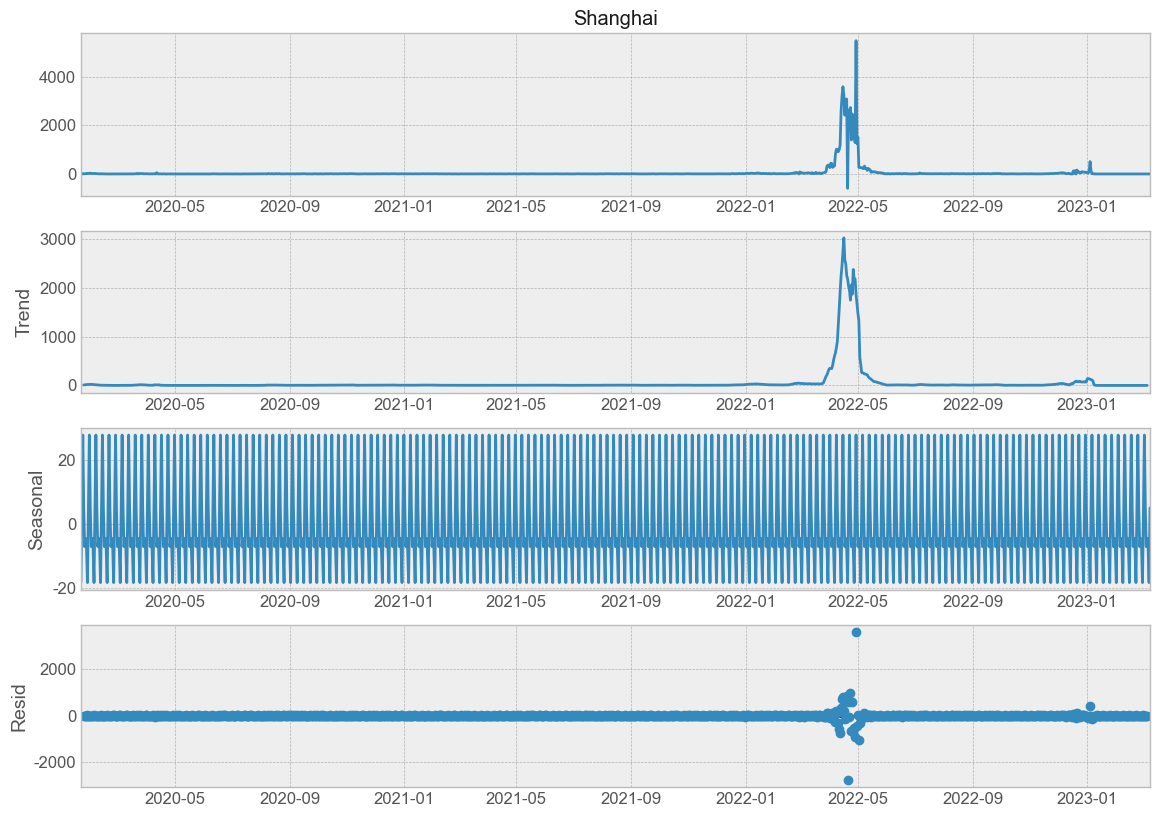

In [392]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

ts_shanghai_confirmed = ts_shanghai_covid['New Local Confirmed Cases']
ts_shanghai_asymptomatic = ts_shanghai_covid['New Local Asymptomatic Cases']
series_2020 = ts_confirmed_CHINA_incre['Shanghai']
result = seasonal_decompose(series_2020, model='additive')
result.plot()
plt.show()

In [393]:
ts_confirmed_CHINA_incre['Shanghai']

2020-01-22     9
2020-01-23     7
2020-01-24     4
2020-01-25    13
2020-01-26     7
              ..
2023-03-05     0
2023-03-06     0
2023-03-07     0
2023-03-08     0
2023-03-09     0
Name: Shanghai, Length: 1143, dtype: int64

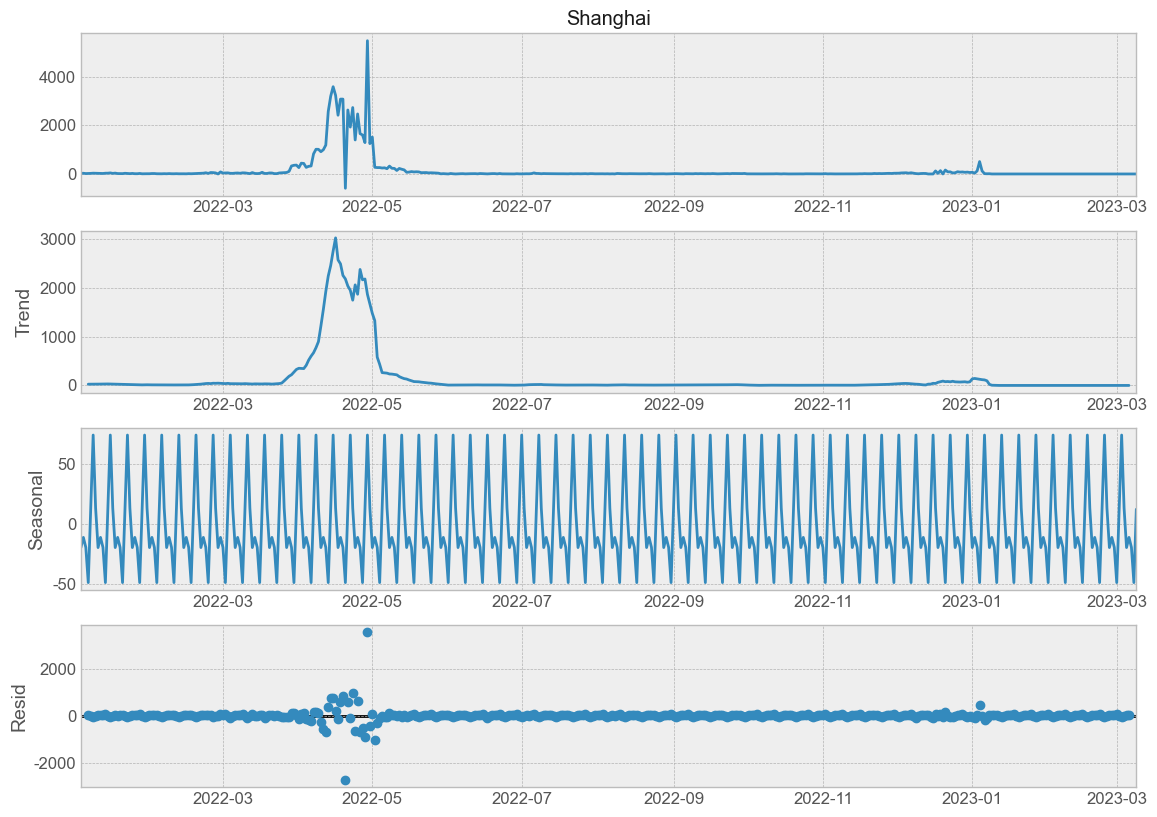

In [394]:
#shanghai
series_2022 = ts_confirmed_CHINA_incre['Shanghai'][ts_confirmed_CHINA_incre['Shanghai'].index>'2022-01-01']
result = seasonal_decompose(series_2022, model='additive')
result.plot()
plt.show() 

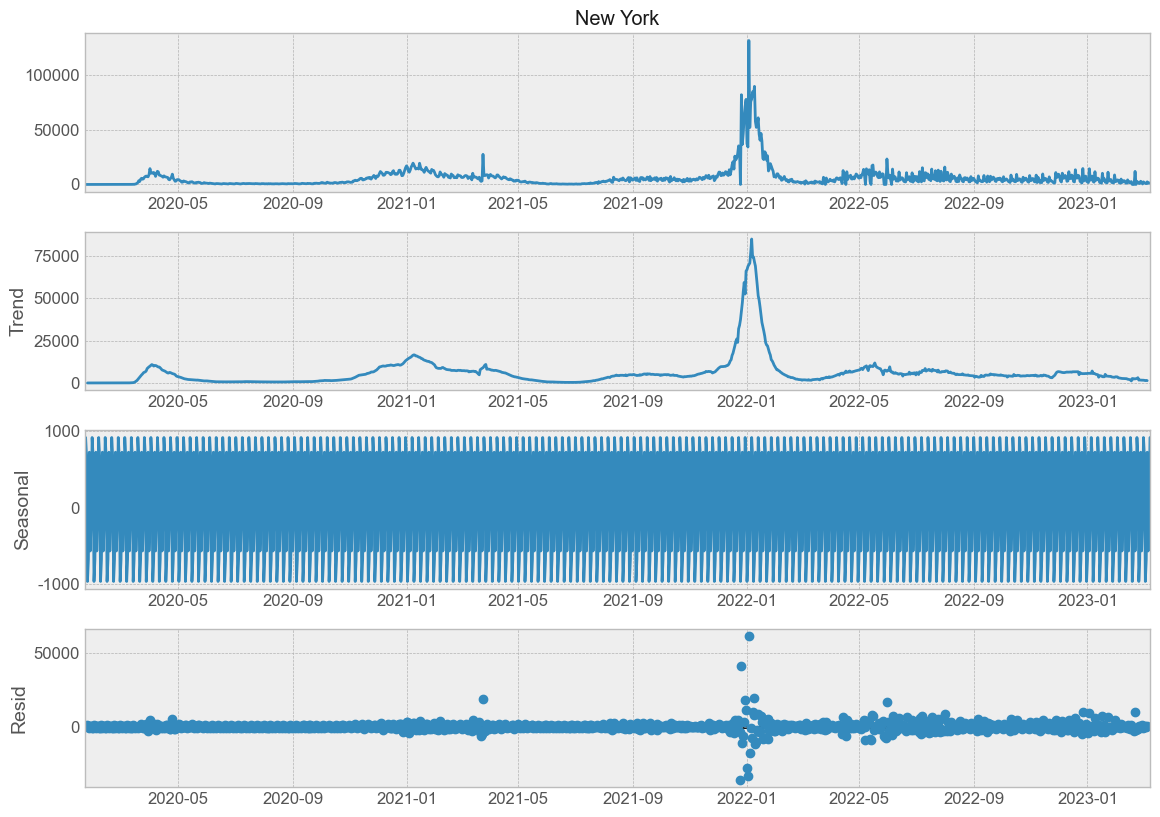

In [395]:
#nyc
nyc_series = ts_confirmed_US_incre['New York']
nyc_result = seasonal_decompose(nyc_series, model='additive')
nyc_result.plot()
plt.show() 

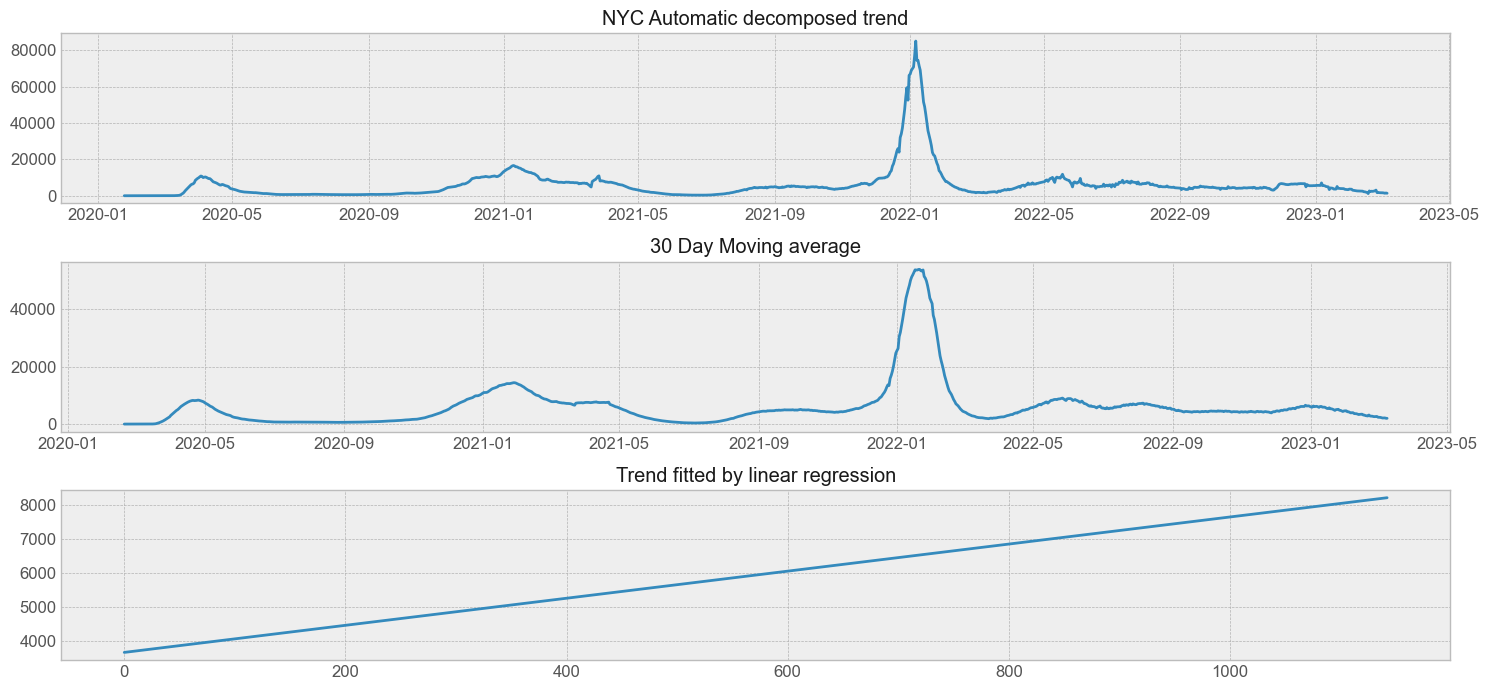

In [396]:
from sklearn.linear_model import LinearRegression
fig = plt.figure(figsize=(15, 7))
layout = (3, 2)
pm_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
mv_ax = plt.subplot2grid(layout, (1, 0), colspan=2)
fit_ax = plt.subplot2grid(layout, (2, 0), colspan=2)

pm_ax.plot(nyc_result.trend)
pm_ax.set_title("NYC Automatic decomposed trend")
 
mm = nyc_series.rolling(30).mean()
mv_ax.plot(mm)
mv_ax.set_title("30 Day Moving average")


X = [i for i in range(0, len(nyc_series))]
X = np.reshape(X, (len(X), 1))
y = nyc_series
model = LinearRegression()
model.fit(X, y)
# calculate trend
trend = model.predict(X)
fit_ax.plot(trend)
fit_ax.set_title("Trend fitted by linear regression")

plt.tight_layout()

Text(0, 0.5, '2022')

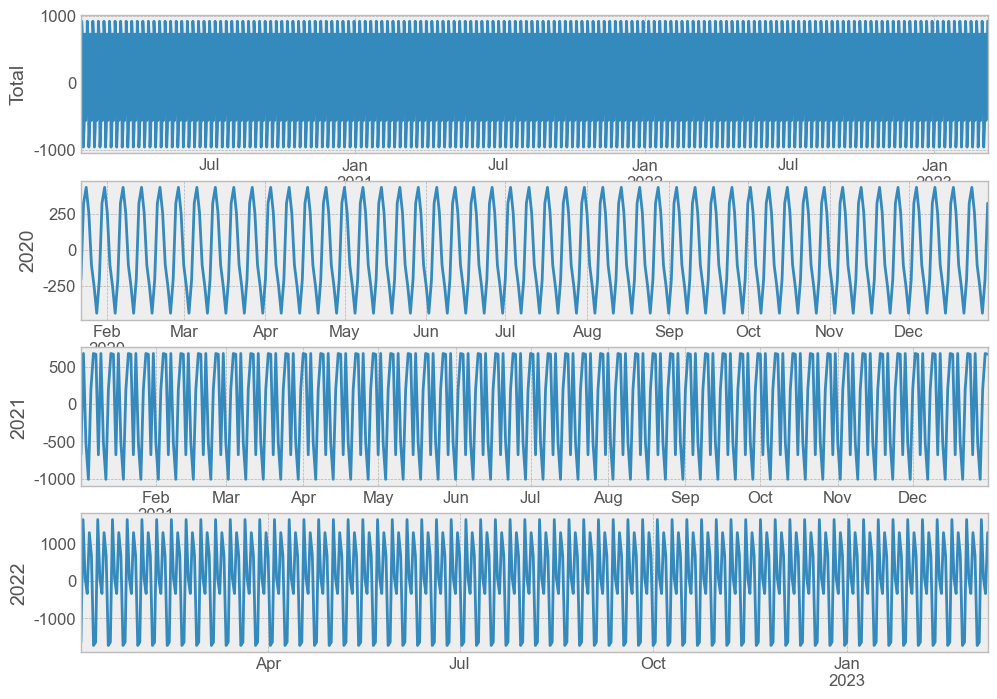

In [397]:
plt.subplot(411)
nyc_series = ts_confirmed_US_incre['New York']
nyc_result = seasonal_decompose(nyc_series, model='additive')
nyc_result.seasonal.plot()
plt.ylabel('Total')
plt.subplot(412)
nyc_series_2020 = ts_confirmed_US_incre['New York'][ts_confirmed_US_incre.index<'2021']
nyc_result_2020 = seasonal_decompose(nyc_series_2020, model='additive')
nyc_result_2020.seasonal.plot()
plt.ylabel('2020')
plt.subplot(413)
nyc_series_2021 = ts_confirmed_US_incre['New York'][(ts_confirmed_US_incre.index>'2021') &(ts_confirmed_US_incre.index<'2022')]
nyc_result_2021 = seasonal_decompose(nyc_series_2021, model='additive')
nyc_result_2021.seasonal.plot()
plt.ylabel('2021')
plt.subplot(414)
nyc_series_2022 = ts_confirmed_US_incre['New York'][ts_confirmed_US_incre.index>'2022']
nyc_result_2022 = seasonal_decompose(nyc_series_2022, model='additive')
nyc_result_2022.seasonal.plot()
plt.ylabel('2022')

Text(0.5, 1.0, 'Mean over time')

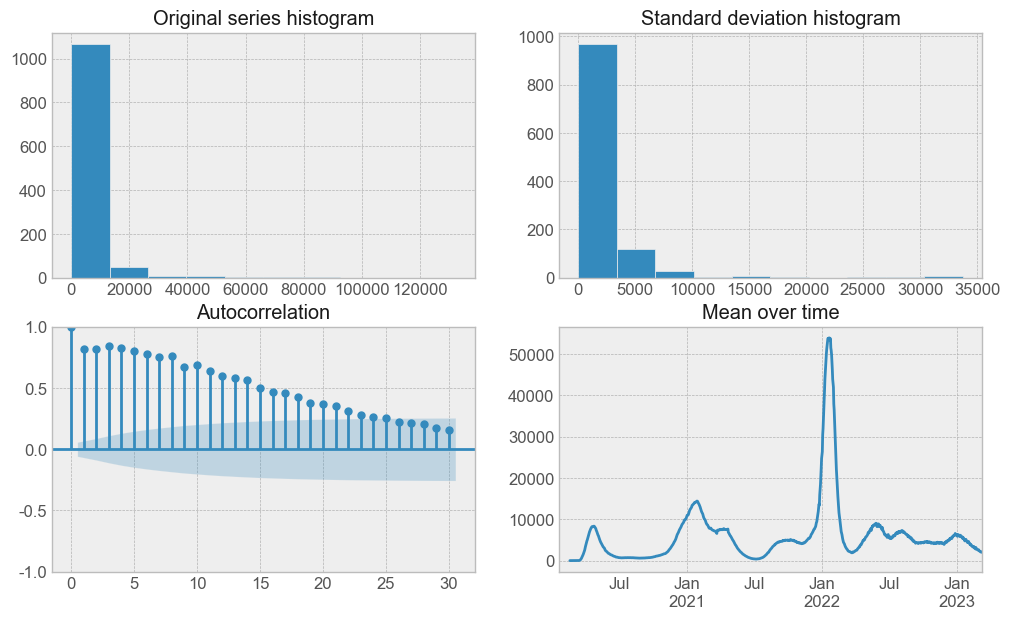

In [398]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

nyc_series.hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(nyc_series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = nyc_series.rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = nyc_series.rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

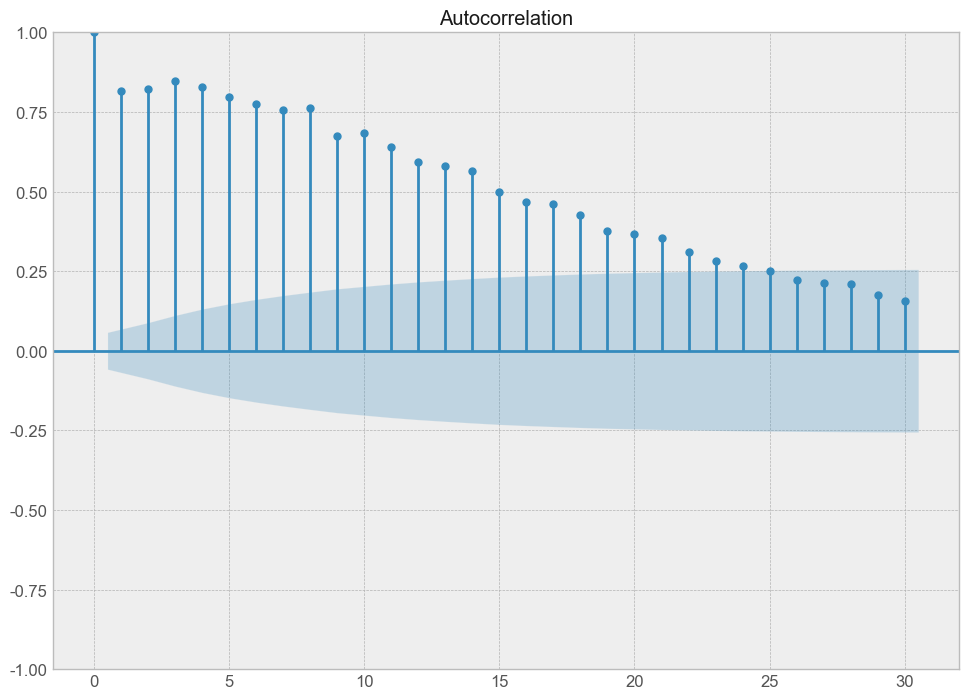

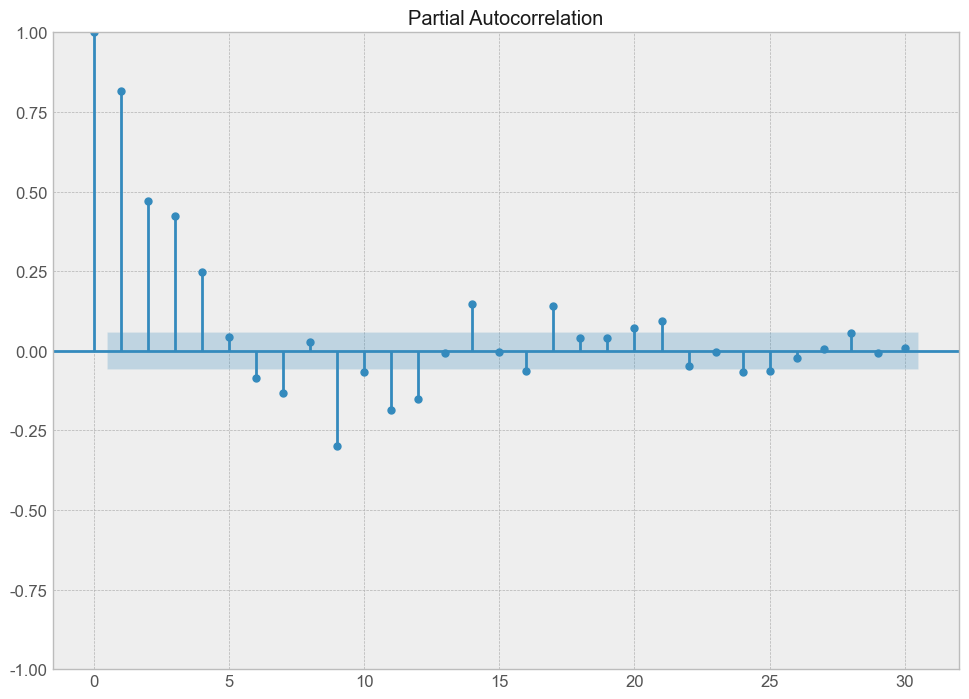

In [399]:
plot_acf(nyc_series, lags=30)
plot_pacf(nyc_series, lags=30)
plt.show()

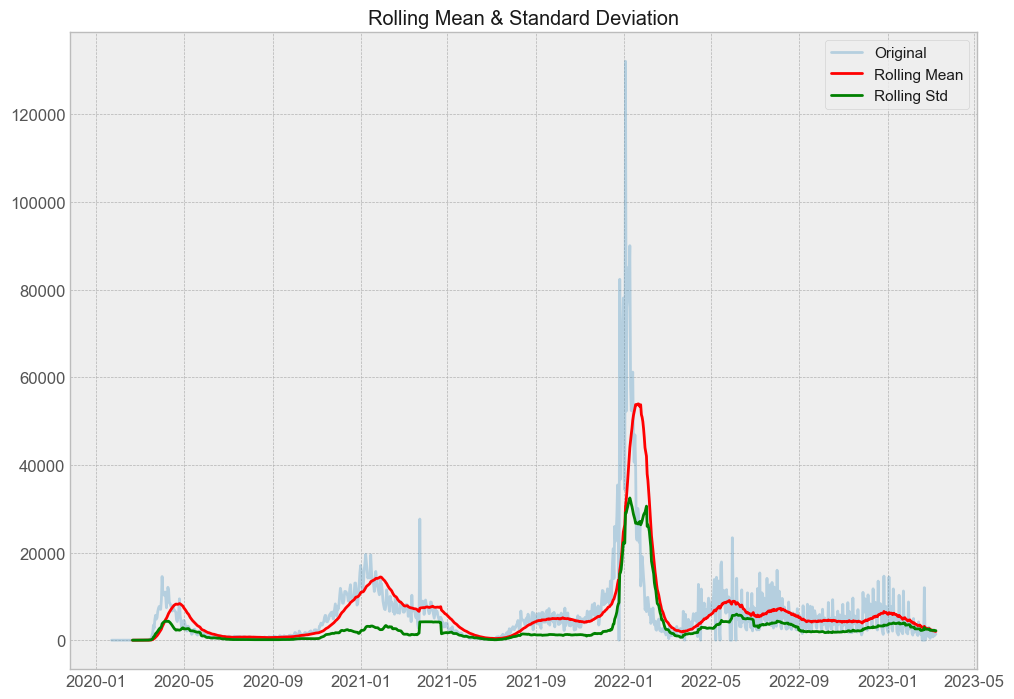

In [404]:
rolmean = nyc_series.rolling(window=30).mean()
rolstd = nyc_series.rolling(window=30).std()

# Plot rolling statistics:
orig = plt.plot(nyc_series, label='Original',alpha = .3)
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='green', label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [407]:
from statsmodels.tsa.stattools import adfuller
X = nyc_series
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.977112
p-value: 0.001535
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


ADF test result: We reject H0 and the series is stationary
ADF test p-value: 0.001535


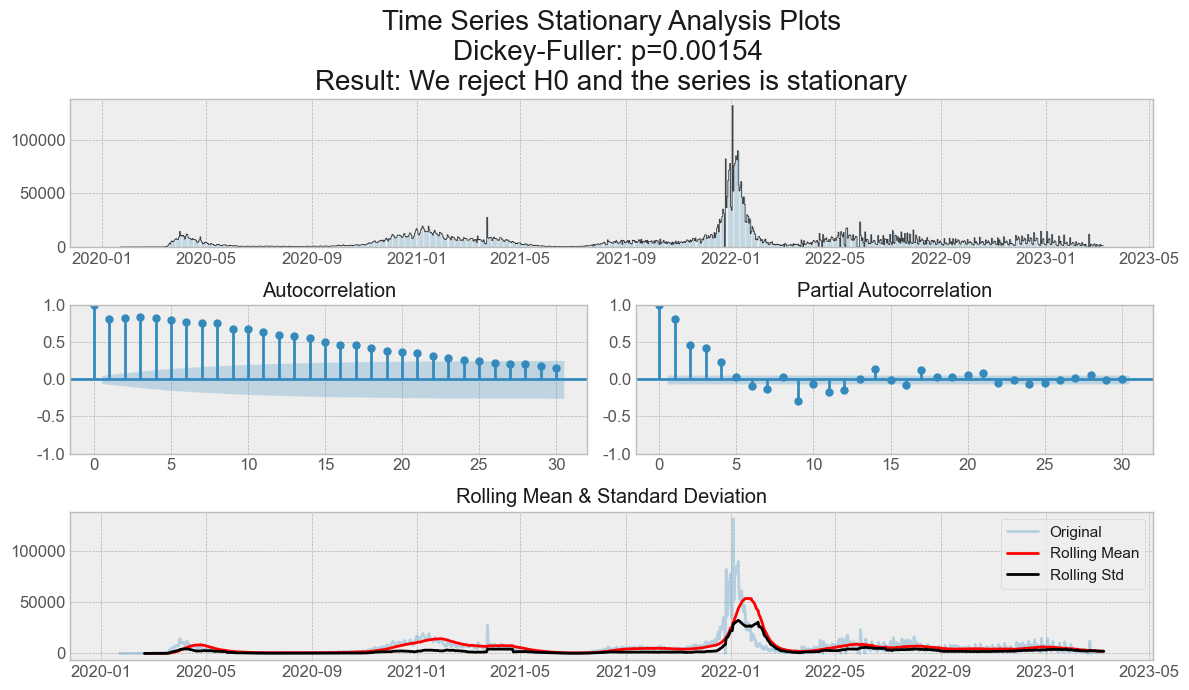

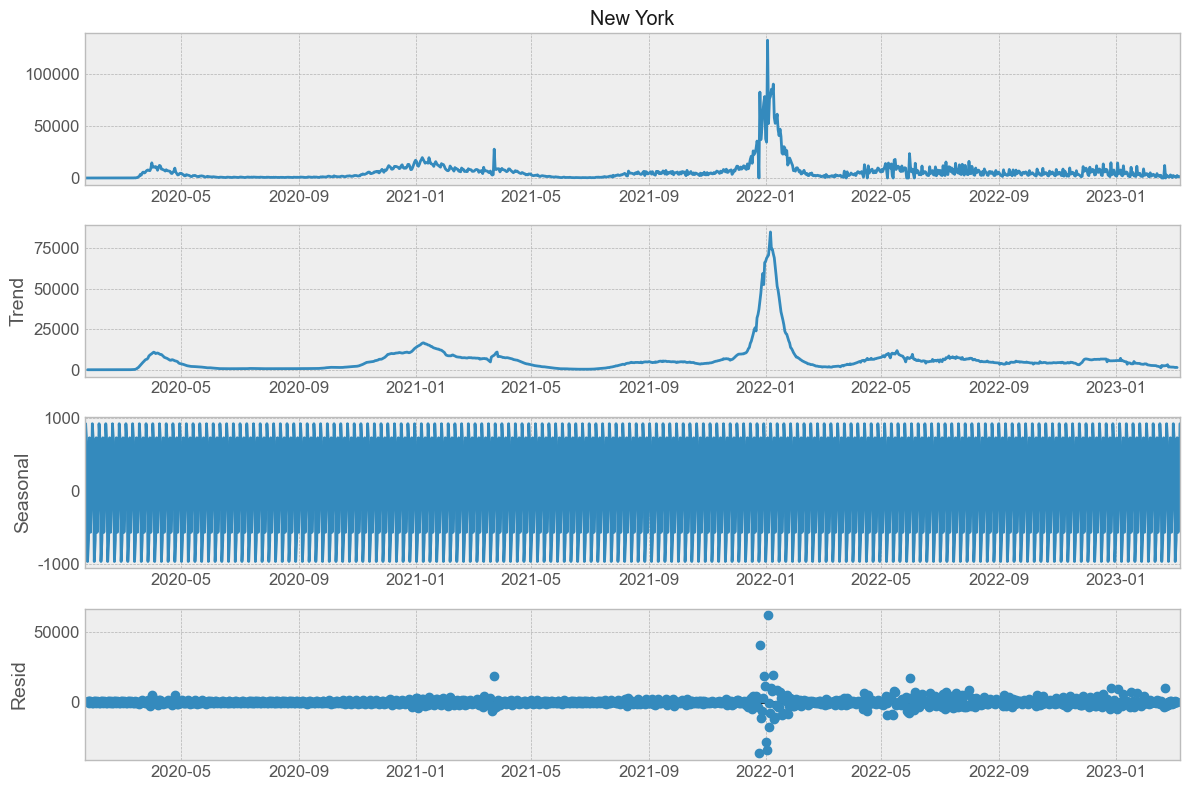

In [412]:
def tsplot(y, lags=None, figsize=(12, 7), ma=30, decompose=True):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        
        # Plot time series as step plot and bar plot
        ts_ax.step(y.index, y, color='#202124', linewidth=0.5)
        ts_ax.bar(y.index, y, alpha=0.8)
        
        # Perform Augmented Dickey-Fuller test for stationarity
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = (
            "We reject H0 and the series is stationary"
            if p_value <= 0.05
            else "We cannot reject H0 and the series is NOT stationary"
        )
        
        # Set plot title with Dickey-Fuller test results
        ts_ax.set_title(
            'Time Series Stationary Analysis Plots\nDickey-Fuller: p={0:.5f} \nResult: {1}'.format(p_value, hypothesis_result),
            fontsize=20
        )
        
        # Plot autocorrelation and partial autocorrelation
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)

        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')

        plt.tight_layout()

        # Calculate rolling mean and rolling standard deviation
        rolmean = y.rolling(window=ma).mean()
        rolstd = y.rolling(window=ma).std()

        # Plot rolling statistics
        orig = plt.plot(y, label='Original', alpha=0.3)
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')
        
        # Print ADF test results with colored output
        print(f"ADF test result: {Fore.RED}{hypothesis_result}{Style.RESET_ALL}")
        print(f"ADF test p-value: {Fore.BLUE}{round(p_value, 6)}{Style.RESET_ALL}")
    
    if decompose:
        plt.rcParams["figure.figsize"] = (12, 8)
        result = seasonal_decompose(y, model='additive')
        result.plot()
        plt.show()

# Example call
tsplot(nyc_series, lags=30)


In [413]:
import os
print(os.getcwd())          # 确认当前工作目录
print(os.listdir())         # 确认metrics.py是否在当前目录


/Users/sinuo/Shanghai_Covid_Predictions
['metrics.py', 'scores.pickle', 'Shanghai_Covid_Cases_Predictions.ipynb', '__pycache__', 'predictions.pickle', '.jovianrc', 'data_processing.py', '.ipynb_checkpoints']


# UnivariateTimeSeriesForecasting

In [855]:
!pip install lightgbm
!pip install pmdarima
!pip install xgboost

import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from metrics import evaluate
import metrics

import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
# from bayes_opt import BayesianOptimization
# from gluonts.dataset.common import ListDataset
# from gluonts.evaluation.backtest import make_evaluation_predictions
# from gluonts.model.deepar import DeepAREstimator
# from gluonts.mx.trainer import Trainer
# from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from rich.progress import track

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8
plt.rcParams['axes.unicode_minus'] = False 

# change text color
import colorama
from colorama import Fore, Style

print(tf.__version__)


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
2.16.2


In [856]:
split_date = '2022-01-01'
df_train = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index < split_date]
df_test = ts_confirmed_US_incre.loc[ts_confirmed_US_incre.index >= split_date]
print(f"{len(df_train)} days of training data \n {len(df_test)} days of testing data ")


710 days of training data 
 433 days of testing data 


In [857]:
resultsDict = {}
predictionsDict = {}

In [858]:

# Calculate the mean of the 'New York' column in the training dataset
mean = df_train['New York'].mean()

# Create an array filled with this mean value, with the same length as the test dataset
mean = np.array([mean for u in range(len(df_test))])

# Evaluate the performance of using the mean as a constant prediction for the test data
resultsDict['Naive mean'] = evaluate(df_test['New York'], mean)

# Store the constant predictions (the mean value repeated) in predictionsDict
predictionsDict['Naive mean'] = mean

# Evaluate the performance of using "yesterday's value" (lag-1) as the prediction
resultsDict['Yesterdays value'] = evaluate(
    df_test['New York'], df_test['New York'].shift(1).fillna(0))

# Store the lag-1 predictions (yesterday's value) in predictionsDict
predictionsDict['Yesterdays value'] = df_test['New York'].shift(1).fillna(0).values



Simple Exponential Smoothing (SES)

In [860]:
# Walk through the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)                           # index represents the number of rows in df_train
yhat = list()                                   # temporary list for storing predictions
for t in track(range(len(df_test['New York']))):     # track is a progress bar tool similar to tqdm, see: https://zhuanlan.zhihu.com/p/470320311
    temp_train = ts_confirmed_US_incre[:len(df_train)+t] # Using nested cross-validation to construct the training set
    model = SimpleExpSmoothing(temp_train['New York'])   # SimpleExpSmoothing is a simple exponential smoothing function, here we build the model
    model_fit = model.fit()                              # fit on training data
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))  # Iterate through test data, train and predict 1 day ahead for all test data
    yhat = yhat + [predictions]    # add predictions to yhat list

yhat_SES = pd.concat(yhat)      
resultsDict['SES'] = evaluate(df_test['New York'], yhat_SES.values)
predictionsDict['SES'] = yhat_SES.values




Output()

Holt Winter’s Exponential Smoothing (HWES)

In [862]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ExponentialSmoothing(temp_train['New York'])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_HWES = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test['New York'], yhat_HWES.values)
predictionsDict['HWES'] = yhat_HWES.values

Output()

Autoregression (AR)

In [864]:
# Walk through the test data, training and predicting 1 day ahead for all the test data
from statsmodels.tsa.ar_model import AutoReg

index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = AutoReg(temp_train['New York'], lags=1)  # lags=1表示用1阶自回归模型，可以根据需要调整
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_AR = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test['New York'], yhat_AR.values)
predictionsDict['AR'] = yhat_AR.values


Output()

Moving Average (MA)

In [866]:

# Walk through the test data, training and predicting 1 day ahead for all the test data
from statsmodels.tsa.arima.model import ARIMA

index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARIMA(temp_train['New York'], order=(0, 0, 1))  # (0,0,1) is MA(1) model
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_MA = pd.concat(yhat)
resultsDict['MA'] = evaluate(df_test['New York'], yhat_MA.values)
predictionsDict['MA'] = yhat_MA.values


Output()

Autoregressive Moving Average (ARMA)

In [868]:
from statsmodels.tsa.arima.model import ARIMA

index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARIMA(temp_train['New York'].diff().fillna(0), order=(1, 0, 1))  # ARMA(1,1) = ARIMA(1,0,1)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_ARMA = pd.concat(yhat)
resultsDict['ARMA'] = evaluate(df_test['New York'], yhat_ARMA.values)
predictionsDict['ARMA'] = yhat_ARMA.values


Output()

Autoregressive integrated moving average (ARIMA)

In [870]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
from statsmodels.tsa.arima.model import ARIMA

index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARIMA(temp_train['New York'], order=(1, 0, 0))
    model_fit = model.fit()  # Removed transparams=False
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat_ARIMA = pd.concat(yhat)
resultsDict['ARIMA'] = evaluate(df_test['New York'], yhat_ARIMA.values)
predictionsDict['ARIMA'] = yhat_ARIMA.values


Output()

In [872]:
autoModel = pm.auto_arima(df_train['New York'], trace=True,
                          error_action='ignore', suppress_warnings=True, seasonal=True)
# autoModel.plot_diagnostics(figsize=(14,10))
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=13347.733, Time=0.46 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=14640.016, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=14145.272, Time=0.03 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=13346.430, Time=0.44 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=13363.877, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=13562.254, Time=0.39 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=13364.415, Time=0.60 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=13346.874, Time=0.67 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=13433.366, Time=0.35 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=13332.877, Time=0.69 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=13340.164, Time=0.42 sec
 ARIMA(2,2,4)(0,0,0)[0]             : AIC=13337.751, Time=0.84 sec
 ARIMA(1,2,4)(0,0,0)[0]             : AIC=inf, Time=0.75 sec
 ARIMA(3,2,2)(0,0,0)[0]        

In [873]:
best_order = autoModel.order
model0 = ARIMA(df_train['New York'], order=best_order)
model_fit0 = model0.fit()  # Removed disp=False
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = ARIMA(temp_train['New York'], order=best_order)
    model_fit = model.fit()  # Removed disp, transparams, start_params
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))  # Removed dynamic=False
    yhat = yhat + [predictions]

yhat_autoarima = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(best_order)] = evaluate(df_test['New York'], yhat_autoarima.values)
predictionsDict['AutoARIMA {0}'.format(best_order)] = yhat_autoarima.values

Output()

Seasonal Autoregressive Integrated Moving-Average (SARIMA)


In [875]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_train)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = SARIMAX(temp_train['New York'],order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit(disp=False,transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),dynamic=False)
    yhat = yhat + [predictions]
    
yhat_SARIMAX = pd.concat(yhat)
resultsDict['SARIMAX'] = evaluate(df_test['New York'], yhat_SARIMAX.values)
predictionsDict['SARIMAX'] = yhat_SARIMAX.values

Output()

Auto - SARIMA

In [877]:
# building the model
autoModel = pm.auto_arima(df_train['New York'], trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True, m=6, stepwise=True)
# autoModel.plot_diagnostics(figsize=(14,10))
# plt.show()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[6]             : AIC=13313.882, Time=1.45 sec
 ARIMA(0,2,0)(0,0,0)[6]             : AIC=14640.016, Time=0.02 sec
 ARIMA(1,2,0)(1,0,0)[6]             : AIC=14146.943, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[6]             : AIC=inf, Time=0.35 sec
 ARIMA(2,2,2)(0,0,1)[6]             : AIC=13327.855, Time=1.01 sec
 ARIMA(2,2,2)(1,0,0)[6]             : AIC=13366.697, Time=0.38 sec
 ARIMA(2,2,2)(2,0,1)[6]             : AIC=13317.209, Time=1.49 sec
 ARIMA(2,2,2)(1,0,2)[6]             : AIC=13319.046, Time=1.68 sec
 ARIMA(2,2,2)(0,0,0)[6]             : AIC=13347.733, Time=0.49 sec
 ARIMA(2,2,2)(0,0,2)[6]             : AIC=13316.638, Time=1.25 sec
 ARIMA(2,2,2)(2,0,0)[6]             : AIC=13363.630, Time=0.58 sec
 ARIMA(2,2,2)(2,0,2)[6]             : AIC=13355.202, Time=1.87 sec
 ARIMA(1,2,2)(1,0,1)[6]             : AIC=inf, Time=1.09 sec
 ARIMA(2,2,1)(1,0,1)[6]             : AIC=13411.955, Time=1.11 sec
 ARIMA(3,2,2)(1,0,1)[6]        

In [878]:
best_order = autoModel.order
seasonalOrder = autoModel.seasonal_order
# model0 = ARIMA(df_train['New York'],order = best_order)
# model_fit0 =model0.fit(disp=False)
yhat = list()
for t in track(range(len(df_test['New York']))):
    temp_train = ts_confirmed_US_incre[:len(df_train)+t]
    model = SARIMAX(temp_train['New York'],
                    order = best_order,
                   seasonal_order=seasonalOrder)
    model_fit = model.fit(disp=False,transparams=False)
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),dynamic=False)
    yhat = yhat + [predictions]
yhat_AutoSARIMAX = pd.concat(yhat)
resultsDict['AutoSARIMAX  {0}'.format(best_order,seasonalOrder)] = evaluate(
    df_test['New York'], yhat_AutoSARIMAX)
predictionsDict['AutoSARIMAX  {0}'.format(best_order,seasonalOrder)] = yhat_AutoSARIMAX.values

Output()

In [907]:
yhat_dict = {
    'SES': yhat_SES,
    'HWES': yhat_HWES,
    'AR': yhat_AR,
    'MA': yhat_MA,
    'ARMA': yhat_ARMA,         
    'ARIMA': yhat_ARIMA,
    'AUTOARIMA': yhat_autoarima,
    'SARIMAX': yhat_SARIMAX,
    'AUTOSARIMAX': yhat_AutoSARIMAX
}



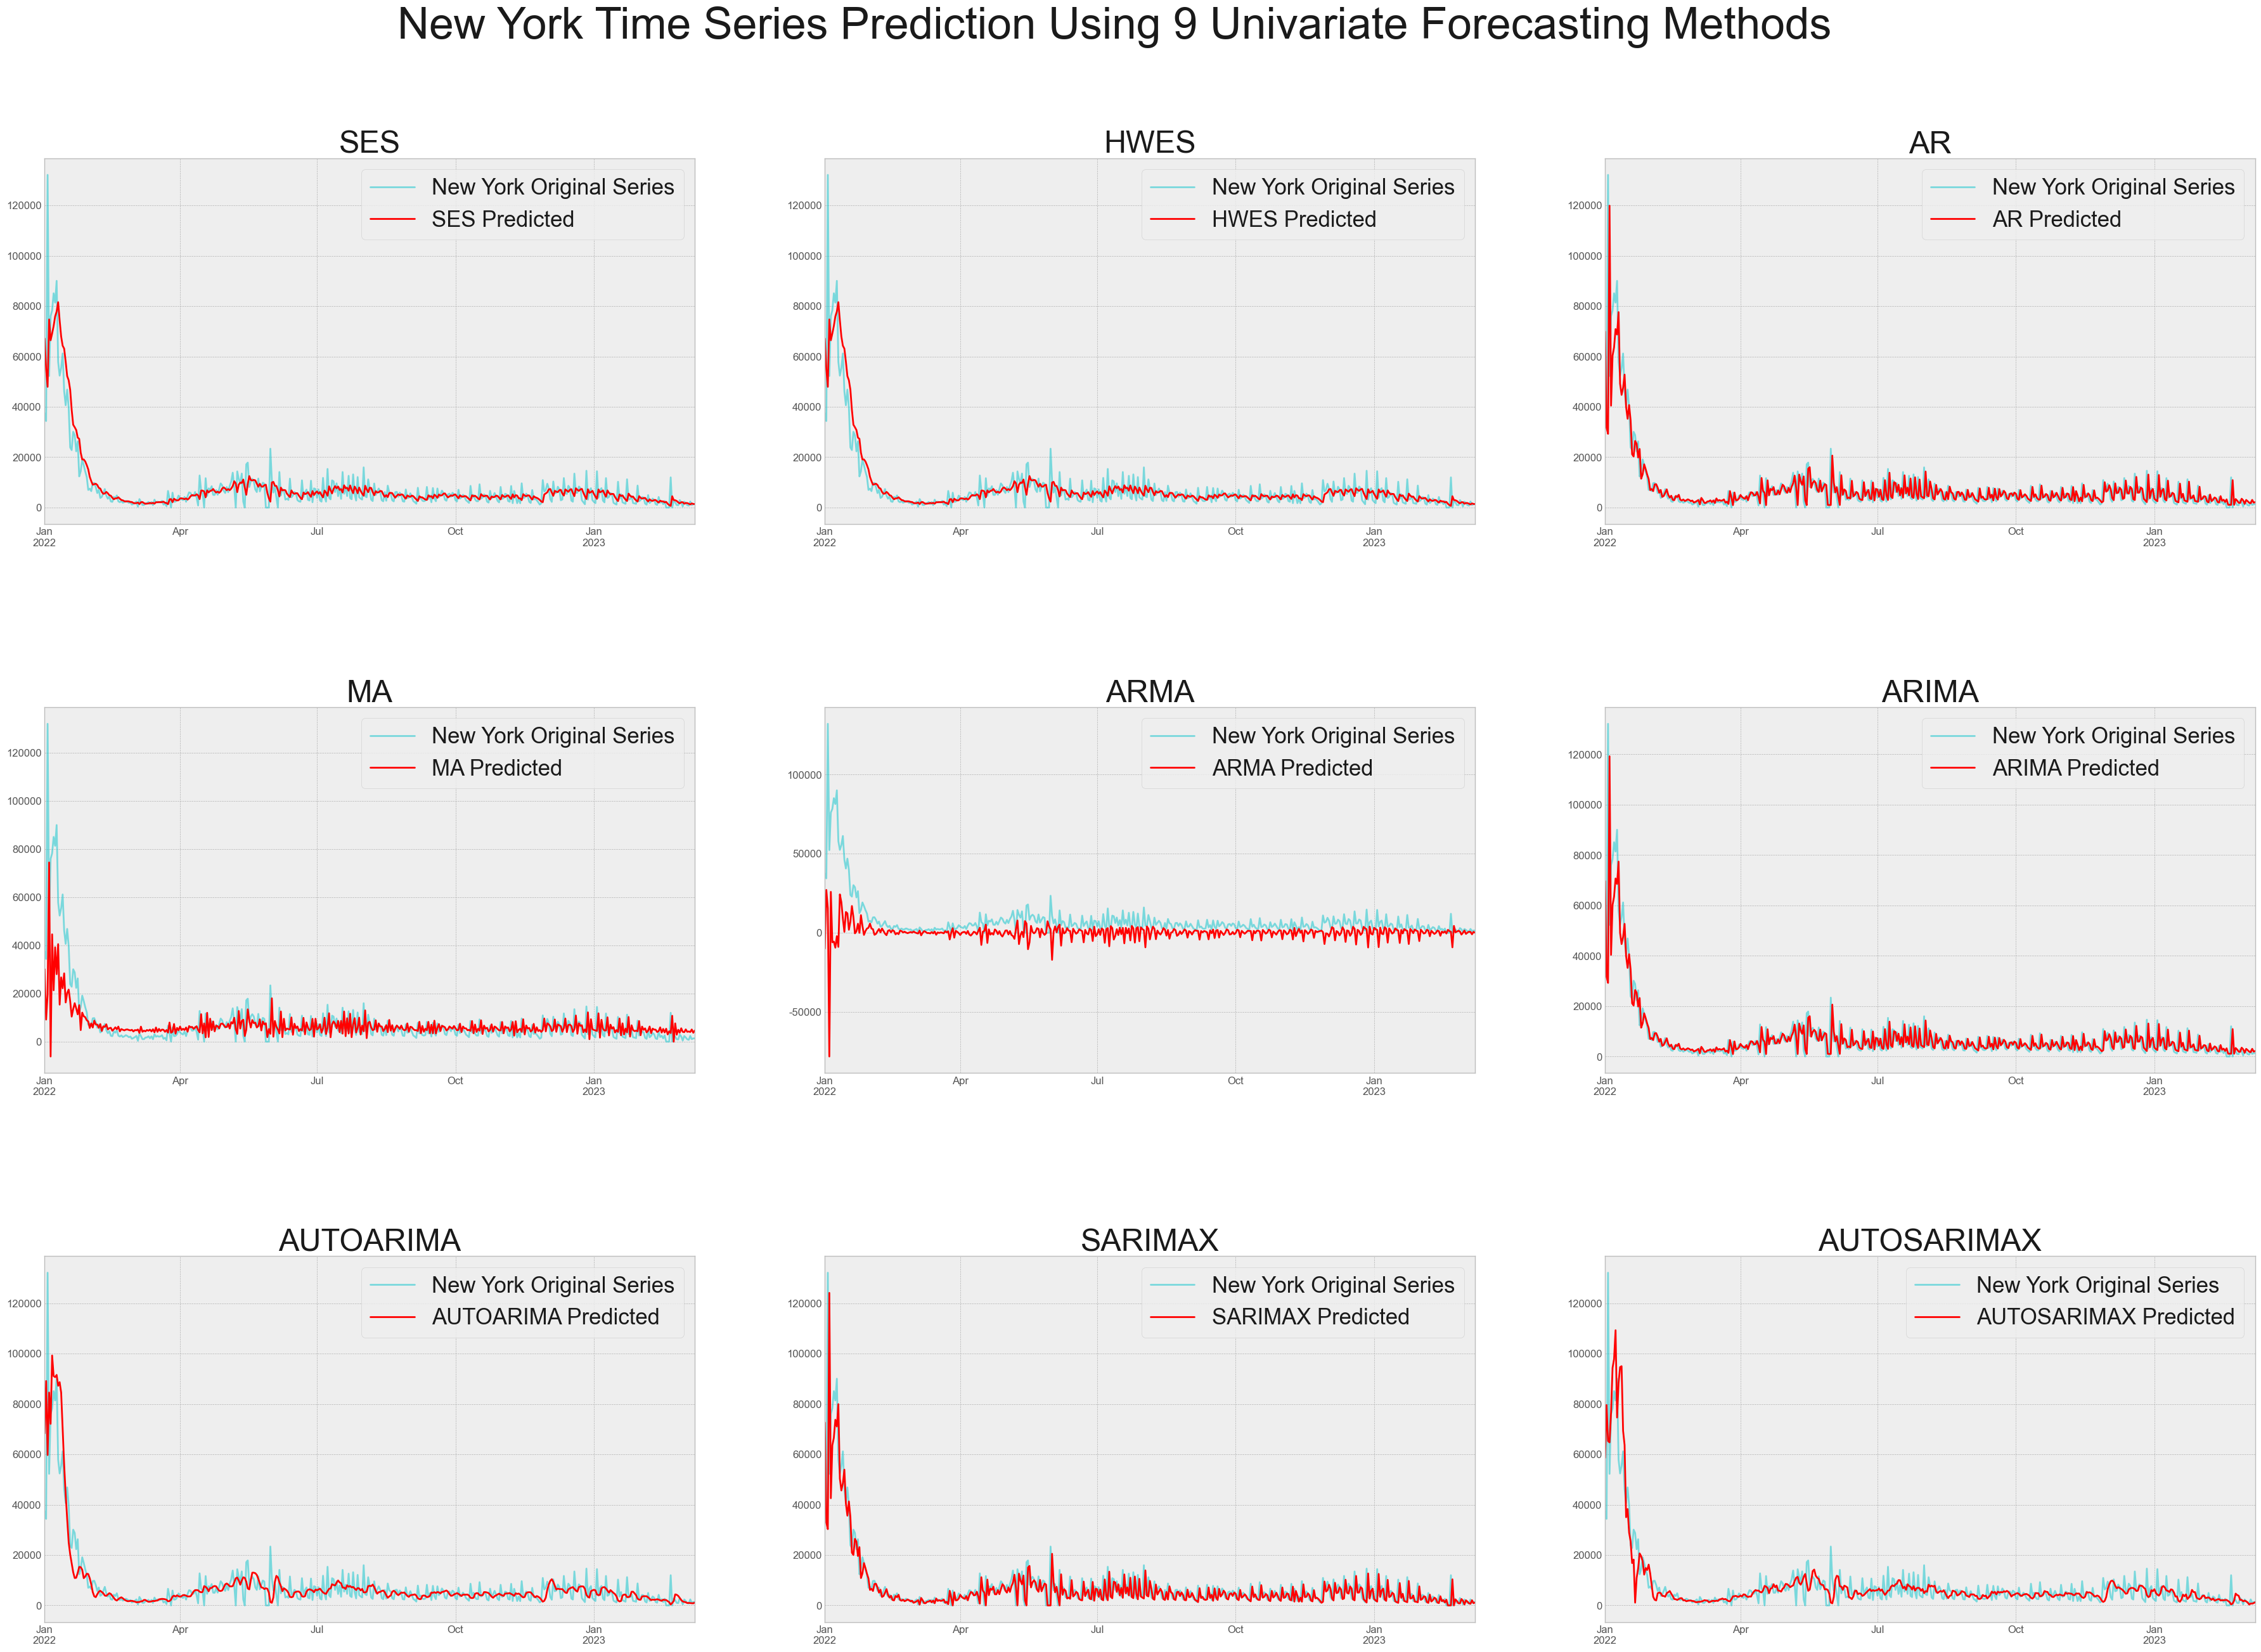

In [909]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(3*15, 10*3))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("New York Time Series Prediction Using 9 Univariate Forecasting Methods", fontsize=50, y = .96)
for yhat_key,ax in zip(yhat_dict.keys(), axs.ravel()):
    df_test['New York'].plot(ax=ax,alpha = .5, label = "New York Original Series", color = '#06c3cc')
    yhat_dict[yhat_key].plot(ax=ax,color = 'red',label=f'{yhat_key} Predicted')
    ax.set_title(f"{yhat_key.upper()}",fontsize = 35)
    ax.legend(fontsize = 25)
    ax.set_xlabel("")
plt.show()

In [911]:
df_train
      

Illinois  California   Ohio  Minnesota  Oklahoma  Massachusetts  \
2020-01-22         0           0      0          0         0              0   
2020-01-23         0           0      0          0         0              0   
2020-01-24         1           0      0          0         0              0   
2020-01-25         0           0      0          0         0              0   
2020-01-26         0           2      0          0         0              0   
...              ...         ...    ...        ...       ...            ...   
2021-12-27     55959       48913   8092       4137      3380          13746   
2021-12-28     20804       29843  15403       9864      2443          10315   
2021-12-29     21107       39972  20320       5210       765          16109   
2021-12-30     30384       54924  19774       6777      4166          22036   
2021-12-31         0       36100  20585          0      3974          22651   

            Nebraska  New York  Utah  New Jersey  ...  hour  dayofweek  \
2020-01-22         0         0     0           0  ...     0          2   
2020-01-23         0         0     0           0  ...     0          3   
2020-01-24         0         0     0           0  ...     0          4   
2020-01-25         0         0     0           0  ...     0          5   
2020-01-26         0         0     0           0  ...     0          6   
...              ...       ...   ...         ...  ...   ...        ...   
2021-12-27      1176     36728  3616        9732  ...     0          0   
2021-12-28      2459     47102  1454       15234  ...     0          1   
2021-12-29      1710     62201  2639       26473  ...     0          2   
2021-12-30      1831     71787  2890       35175  ...     0          3   
2021-12-31         0     78090     0       33724  ...     0          4   

            quarter  month  year  dayofyear   sin_day   cos_day  dayofmonth  \
2020-01-22        1      1  2020         22 -0.008851 -0.999961          22   
2020-01-23        1      1  2020         23 -0.846220 -0.532833          23   
2020-01-24        1      1  2020         24 -0.905578  0.424179          24   
2020-01-25        1      1  2020         25 -0.132352  0.991203          25   
2020-01-26        1      1  2020         26  0.762558  0.646919          26   
...             ...    ...   ...        ...       ...       ...         ...   
2021-12-27        4     12  2021        361  0.279387 -0.960179          27   
2021-12-28        4     12  2021        362 -0.657009 -0.753882          28   
2021-12-29        4     12  2021        363 -0.989354  0.145530          29   
2021-12-30        4     12  2021        364 -0.412091  0.911143          30   
2021-12-31        4     12  2021        365  0.544046  0.839055          31   

            weekofyear  
2020-01-22           4  
2020-01-23           4  
2020-01-24           4  
2020-01-25           4  
2020-01-26           4  
...                ...  
2021-12-27          52  
2021-12-28          52  
2021-12-29          52  
2021-12-30          52  
2021-12-31          52  

[710 rows x 63 columns]

In [913]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb
from sklearn import linear_model, svm
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Multivariate time series forecasting

In [916]:
def gen_time_feat(df, target=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [918]:
X_train_df, y_train = gen_time_feat(df_train, target='New York')
X_test_df, y_test = gen_time_feat(df_test, target='New York')

In [920]:

scaler = StandardScaler()

# Fit the scaler on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# Convert back to DataFrames with original column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_df.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_df.columns)

Bayesian regression

In [923]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat_BayesianRidge = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test['New York'], yhat_BayesianRidge)
predictionsDict['BayesianRidge'] = yhat_BayesianRidge

LARS Lasso

In [926]:
reg = linear_model.LassoLars(alpha=0.1)
reg.fit(X_train, y_train)
yhat_LassoLars = reg.predict(X_test)
resultsDict['LassoLars'] = evaluate(df_test['New York'], yhat_LassoLars)
predictionsDict['LassoLars'] = yhat_LassoLars

Automatic Relevance Determination Regression (ARD)

In [929]:
reg = linear_model.ARDRegression(compute_score=True)
reg.fit(X_train, y_train)
yhat_ARDRegression = reg.predict(X_test)
resultsDict['ARDRegression'] = evaluate(df_test['New York'], yhat_ARDRegression)
predictionsDict['ARDRegression'] = yhat_ARDRegression

Decision Tree

In [932]:
reg = DecisionTreeRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat_DecisionTree = reg.predict(X_test)
resultsDict['DecisionTree'] = evaluate(df_test['New York'], yhat_DecisionTree)
predictionsDict['DecisionTree'] = yhat_DecisionTree

Randomforest

In [934]:
reg = RandomForestRegressor(max_depth=2, random_state=0)
reg.fit(X_train, y_train)
yhat_RandomForest = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test['New York'],yhat_RandomForest)
predictionsDict['Randomforest'] = yhat_RandomForest

Adaboost

In [937]:

reg = AdaBoostRegressor(random_state=0, n_estimators=100)
reg.fit(X_train, y_train)
yhat_AdaBoost = reg.predict(X_test)
resultsDict['AdaBoost'] = evaluate(df_test['New York'],yhat_AdaBoost)
predictionsDict['AdaBoost'] = yhat_AdaBoost

XGBoost

In [940]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train, y_train,
        verbose=False)  # Change verbose to True if you want to see it train
yhat_XGBoost = reg.predict(X_test)
resultsDict['XGBoost'] = evaluate(df_test['New York'], yhat_XGBoost)
predictionsDict['XGBoost'] = yhat_XGBoost

Lightgbm

In [945]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train, y_train)
yhat_lightGBM = lightGBM.predict(X_test)
resultsDict['Lightgbm'] = evaluate(df_test['New York'], yhat_lightGBM)
predictionsDict['Lightgbm'] = yhat_lightGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12182
[LightGBM] [Info] Number of data points in the train set: 710, number of used features: 60
[LightGBM] [Info] Start training from score 4901.802817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

Support Vector Regressor

In [947]:
reg = svm.SVR()
reg.fit(X_train, y_train)
yhat_SVR = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test['New York'], yhat_SVR)
predictionsDict['SVM RBF'] = yhat_SVR

Nearest neighbors

In [951]:
reg = KNeighborsRegressor(n_neighbors=3)
reg.fit(X_train, y_train)
yhat_KNN = reg.predict(X_test)
resultsDict['KNN'] = evaluate(df_test['New York'], yhat_KNN)
predictionsDict['KNN'] = yhat_KNN

Deep Learning

In [954]:
# For our dl model we will create windows of data that will be feeded into the datasets, for each timestemp T we will append the data from T-7 to T to the Xdata with target Y(t)
BATCH_SIZE = 32
BUFFER_SIZE = 64
WINDOW_LENGTH = 12


def window_data(X, Y, window=7):
    '''
    The dataset length will be reduced to guarante all samples have the window, so new length will be len(dataset)-window
    '''
    x = []
    y = []
    for i in range(window-1, len(X)):
        x.append(X[i-window+1:i+1])
        y.append(Y[i])
    return np.array(x), np.array(y)


# Since we are doing sliding, we need to join the datasets again of train and test
X_w = np.concatenate((X_train, X_test))
y_w = np.concatenate((y_train, y_test))

X_w, y_w = window_data(X_w, y_w, window=WINDOW_LENGTH)
X_train_w = X_w[:-len(X_test)]
y_train_w = y_w[:-len(X_test)]
X_test_w = X_w[-len(X_test):]
y_test_w = y_w[-len(X_test):]

# Check we will have same test set as in the previous models, make sure we didnt screw up on the windowing
print(f"Test set equal: {np.array_equal(y_test_w,y_test)}")

train_data = tf.data.Dataset.from_tensor_slices((X_train_w, y_train_w))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data = tf.data.Dataset.from_tensor_slices((X_test_w, y_test_w))
val_data = val_data.batch(BATCH_SIZE).repeat()

Test set equal: True


In [956]:
dropout = 0.0
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(
        128, input_shape=X_train_w.shape[-2:], dropout=dropout),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1)
])

lstm_model.compile(optimizer='rmsprop', loss='mae')

In [958]:
EVALUATION_INTERVAL = 200
EPOCHS = 20

model_history = lstm_model.fit(train_data, epochs=EPOCHS,
                                      steps_per_epoch=EVALUATION_INTERVAL,
                                      validation_data=val_data, validation_steps=50)  # ,call

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 5:02 2s/step - loss: 3603.426 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2882.254 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2866.984 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3206.960 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3496.971 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3675.647 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3771.282 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3845.712 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3915.887 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3966.462 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3990.258 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4014.277 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4031.283 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4046.544 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4051.607 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4051.632 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4049.635 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4045.410 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4036.777 ━━━━━━━━━━━━

In [960]:
yhat_LSTM = lstm_model.predict(X_test_w).reshape(1, -1)[0]
resultsDict['Tensorflow simple LSTM'] = evaluate(y_test, yhat_LSTM)
predictionsDict['Tensorflow simple LSTM'] = yhat_LSTM

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/st ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/ste ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [962]:
with open('scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [964]:
result_df = pd.DataFrame.from_dict(resultsDict).T
result_df

mae          rmse          mape        r2
Naive mean              5223.664509  13182.630718  1.358467e+12 -0.045595
Yesterdays value        3748.558891   8085.571694  1.104827e+12  0.606648
SES                     3185.882812   6336.717339  1.433454e+12  0.758405
HWES                    3185.882812   6336.717339  1.433454e+12  0.758405
AR                      3695.227066   7913.630603  1.209220e+12  0.623200
MA                      4698.931935  10180.522364  1.430739e+12  0.376409
ARMA                    7603.669042  15433.486006  8.969229e+11 -0.433136
ARIMA                   3692.915845   7903.150174  1.208260e+12  0.624197
AutoARIMA (2, 2, 3)     3316.304596   6839.037379  1.558081e+12  0.718584
SARIMAX                 3595.963898   7990.340958  9.652399e+11  0.615860
AutoSARIMAX  (2, 2, 2)  3347.164408   6757.941725  1.579976e+12  0.725218
BayesianRidge           5601.020107   9218.796092  1.463539e+12  0.488662
LassoLars               6187.595353  10132.465848  1.590788e+12  0.382283
ARDRegression           5662.176798   9193.163005  1.532492e+12  0.491502
DecisionTree            3770.658673   7383.170895  1.431424e+12  0.672022
Randomforest            3504.069463   6363.584602  1.458820e+12  0.756352
AdaBoost                3579.698072   8137.768097  1.296444e+12  0.601553
XGBoost                 3631.801385   6974.745620  1.477927e+12  0.707304
Lightgbm                4516.399816   8295.603035  1.548567e+12  0.585948
SVM RBF                 5323.963386  13627.540619  8.815193e+11 -0.117363
KNN                     4065.017706   7556.183103  7.128637e+11  0.656470
Tensorflow simple LSTM  3635.712548   7385.743733  8.301869e+11  0.671793

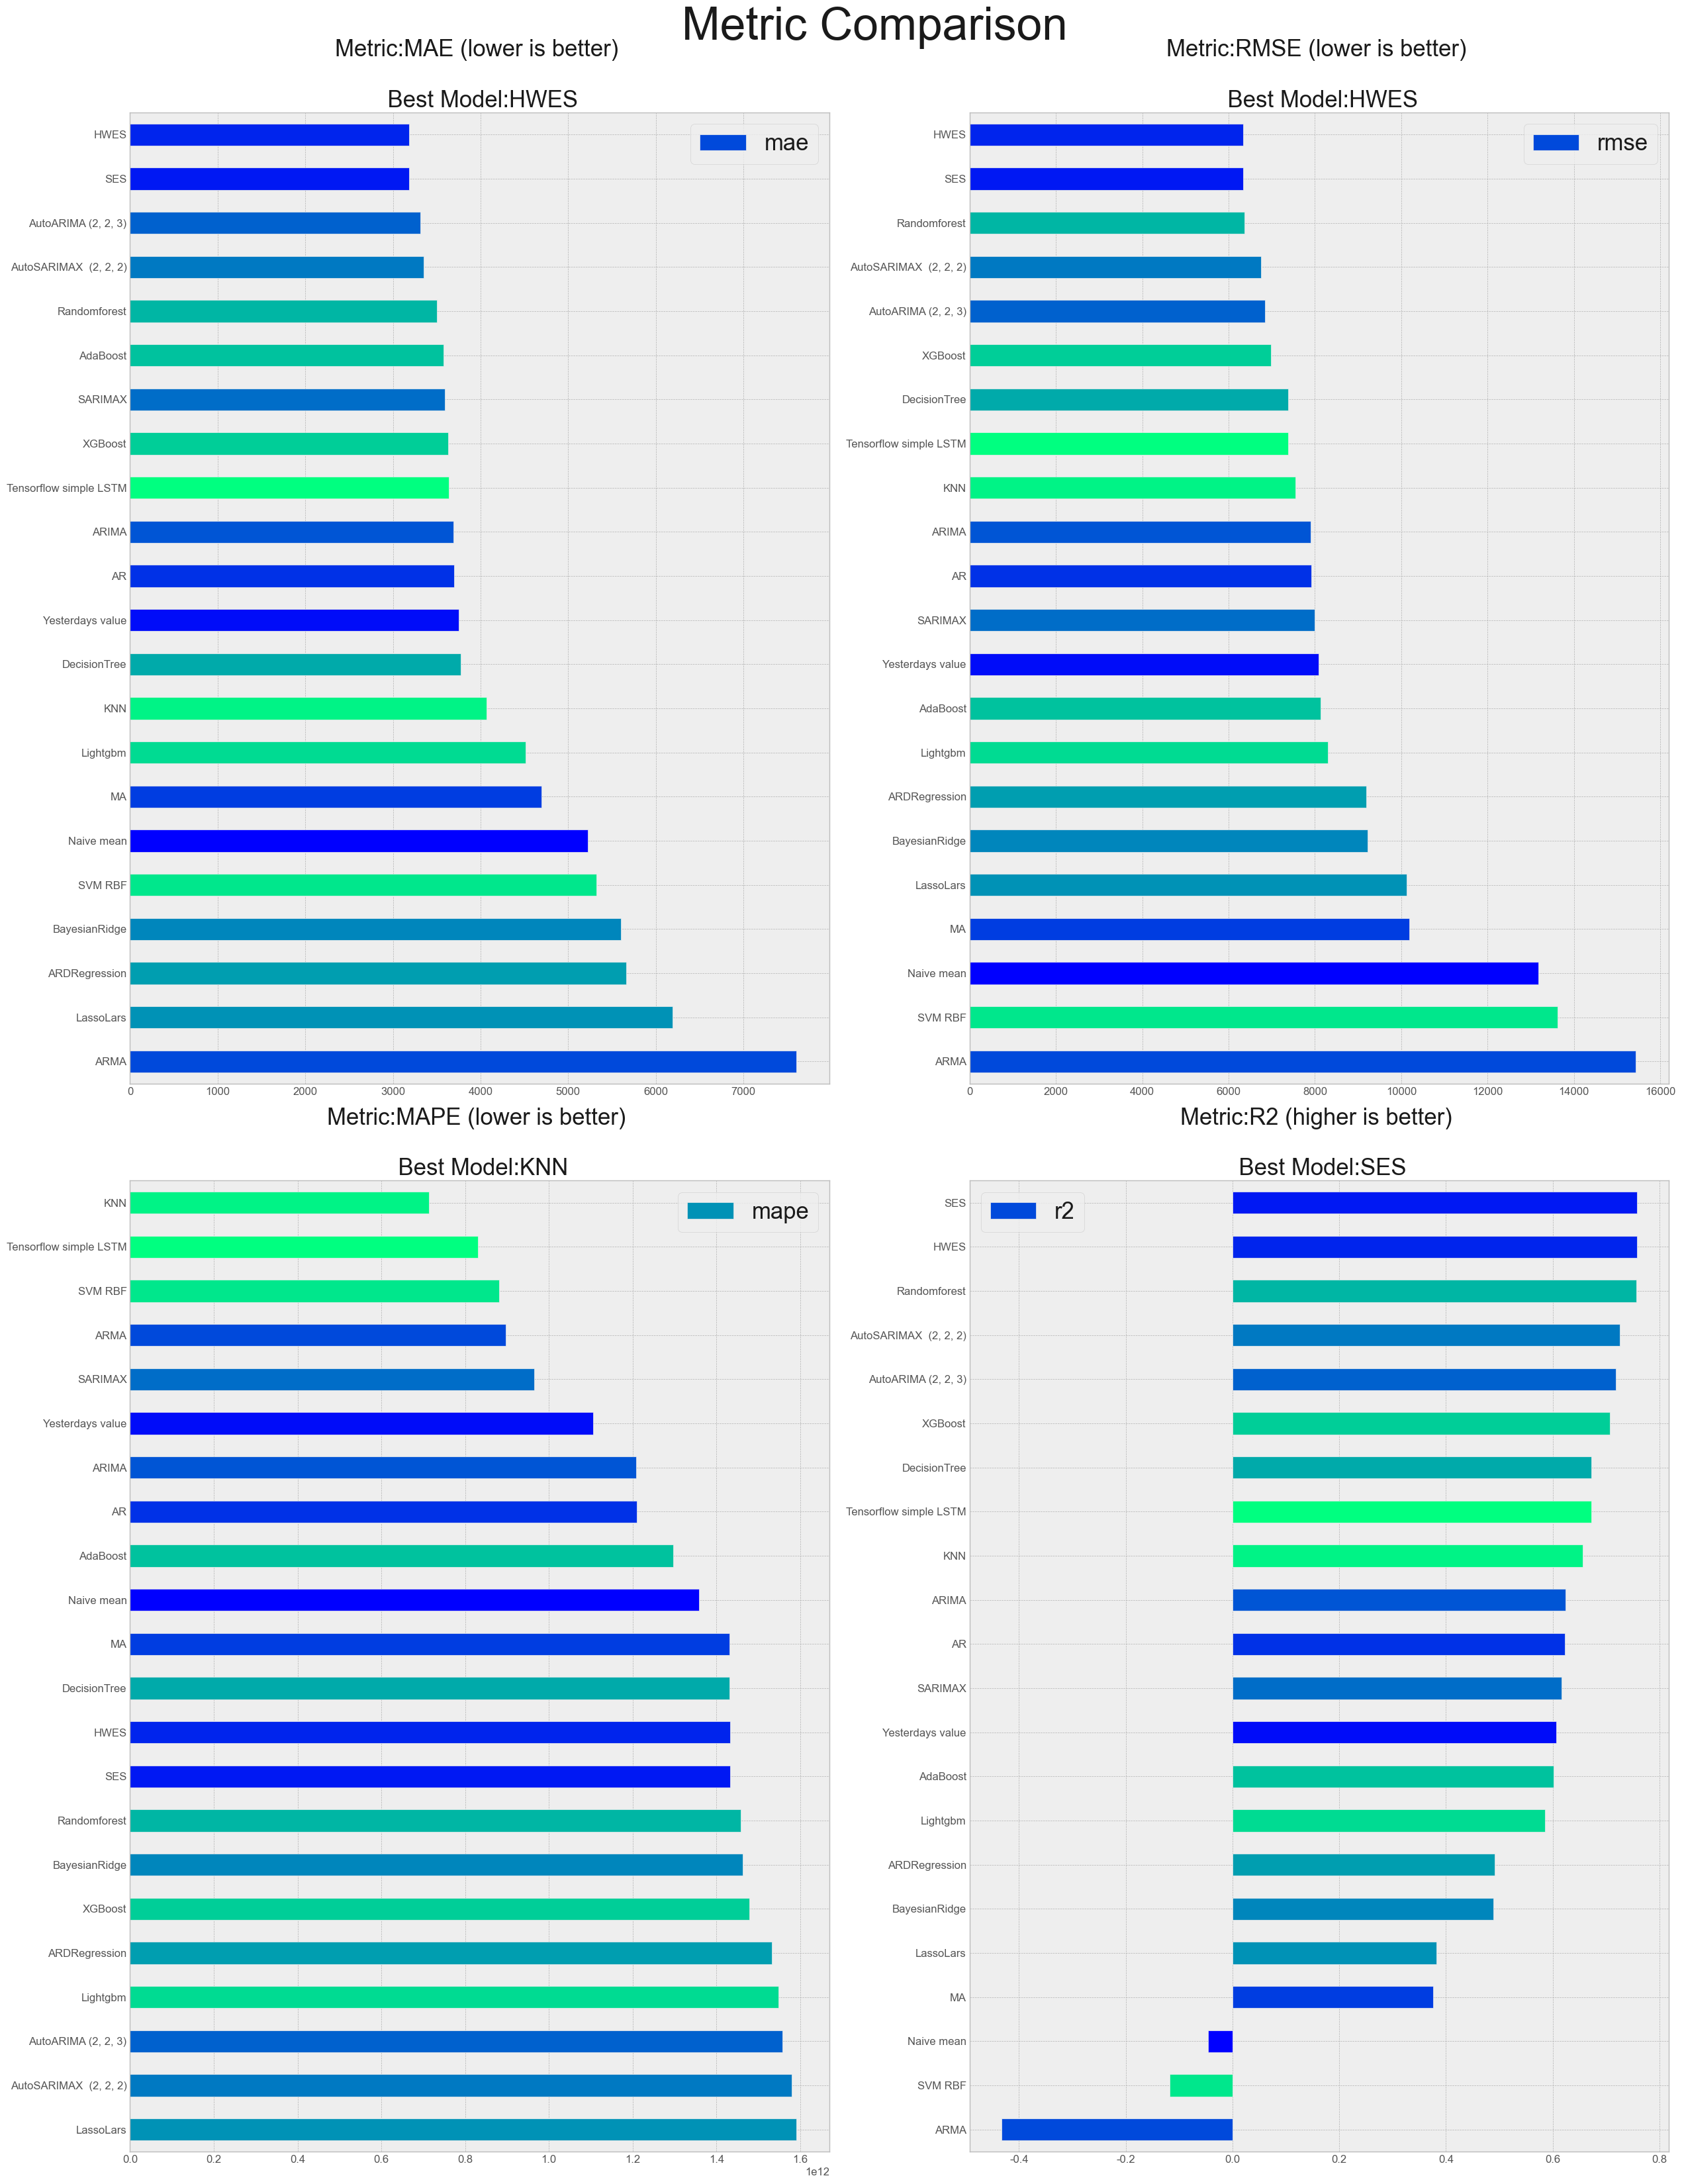

<Figure size 1800x800 with 0 Axes>

In [966]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2*15, 20*2))
plt.subplots_adjust(hspace=0.1)
plt.suptitle("Metric Comparison", fontsize=50, y = .92)

idx = result_df.index
cols = result_df.columns
pallette = plt.cm.get_cmap("winter", len(idx))
colors = [pallette(x) for x in range(len(idx))]
color_dict = dict(zip(idx, colors))
for metric,ax in zip(result_df.columns, axs.ravel()):
    if metric != 'r2':
        df = result_df[metric].sort_values(ascending=False)
        df.plot(
            ax=ax,
            kind = 'barh',
            colormap="Paired",
            color=[color_dict.get(x, "#ff7f00") for x in df.index],
            label = metric
        )
        ax.set_title(f"Metric:{metric.upper()} (lower is better) \n\n Best Model:{df.index[-1]}",fontsize = 25)

    else:
        df = result_df[metric].sort_values()
        df.plot(
            ax=ax,
            kind = 'barh',
            colormap="Paired",
            color=[color_dict.get(x, "#ff7f00") for x in df.index],
            label = metric
        )
        ax.set_title(f"Metric:{metric.upper()} (higher is better) \n\n Best Model:{df.index[-1]}",fontsize = 25)
        
    ax.legend(fontsize = 25)
    ax.set_xlabel("")
plt.show()
plt.tight_layout()